# Scripts for training natural product activity classifiers
all code by Allison Walker

# Process antiSMASH files
processes antiSMASH files stored in the antiSMASH_output directory to identify features. Feature lists and matrices are written to the feature_matrices folder.

In [1]:
import os
from Bio import SeqIO

def processCDSMotif(feature):
    note_text = feature.qualifiers['note'][0]
    if "(" not in note_text: #CDS name not formatted properly
        return None
    motif_name = note_text[0:note_text.index("(")-1]
    return motif_name

def processCDS(feature):
    smCOG_type = None
    for note in feature.qualifiers["note"]:
        if "smCOG" in note:
            if ":" not in note or "(" not in note:
                continue
            smCOG_type = note[note.index(":")+2:note.index("(")-1]
    return smCOG_type

def getFeatureList(feature_dictionary):
    feature_list = []
    feature_counts = {}
    for cluster in feature_dictionary:
        for feature in feature_dictionary[cluster]:
            if feature not in feature_list:
                feature_list.append(feature)
                feature_counts[feature] = 0
            feature_counts[feature] += 1
                
    return (feature_list, feature_counts)
    
def filterLowCounts(feature_list, feature_counts, threshold):
    new_feature_list = []
    for f in feature_list:
        if feature_counts[f] >= threshold:
            new_feature_list.append(f)
    return new_feature_list

#find name of PFAM domain if score is less than cutoff
#default cutoff is 20
def processPFAM(feature, score_cutoff=20):
    score = float(feature.qualifiers["score"][0])
    if score <score_cutoff:
        return None, None
    domain_description = feature.qualifiers["description"][0]
    pfam_id = feature.qualifiers["db_xref"][0]
    pfam_id = pfam_id[pfam_id.find(" ")+1:len(pfam_id)]
    return domain_description, pfam_id

#write a matrix with counts of features to a file and a list of the features to a separate file
def writeFeatureMatrixFile(feature_dictionary, feature_list, output_dir, feature_name):
    matrix_outfile = open(output_dir + feature_name + ".csv", 'w')
    list_outfile = open(output_dir + feature_name + "_list.txt",'w')
    for cluster in feature_dictionary:
        for feature in feature_list:
            if feature in feature_dictionary[cluster]:
                matrix_outfile.write(str(feature_dictionary[cluster][feature]) + ",")
            else:
                matrix_outfile.write("0,")
        matrix_outfile.write("\n")
    matrix_outfile.close()
    
    for f in feature_list:
        list_outfile.write(f + "\n")
    list_outfile.close()
        

#parameters
score_cutoff = 20 #PFAM HMM score to be counted
feature_count_threshold = 5 #features must occur more then this number of times in dataset to be included

input_dir = "antiSMASH_output/"
output_dir = "feature_matrices/"
CDS_motifs = {}
CDS_motif_list = []
CDS_total_counts = {}
smCOGs = {}
smCOG_list = []
smCOG_total_counts = {}
pfam_list = []
pfam_id_list = []
pfam_counts = {}
pfam_total_counts = {}
pks_nrp_subtypes = {}
pk_monomers_signature = {}
pk_monomers_minowa = {}
pk_monomers_consensus = {}
nrp_monomers_stachelhaus = {}
nrp_monomers_nrps_predictor = {}
nrp_monomers_pHMM = {}
nrp_monomers_predicat = {}
nrp_monomers_sandpuma = {}

for f in os.listdir(input_dir):
    if ".gbk" not in f or ".gb" not in f: #skip files that do not have genbank extension
        continue
    record = SeqIO.read(open(input_dir + f, 'rU'),"genbank")
    features = record.features
    cluster_name = f[0:f.index(".")]
    CDS_motifs[cluster_name] = {}
    smCOGs[cluster_name] = {}
    pfam_counts[cluster_name] = {}
    pks_nrp_subtypes[cluster_name] = {}
    pk_monomers_signature[cluster_name] = {}
    pk_monomers_minowa[cluster_name] = {}
    pk_monomers_consensus[cluster_name] = {}
    nrp_monomers_stachelhaus[cluster_name] = {}
    nrp_monomers_nrps_predictor[cluster_name] = {}
    nrp_monomers_pHMM[cluster_name] = {}
    nrp_monomers_predicat[cluster_name] = {}
    nrp_monomers_sandpuma[cluster_name] = {}
    
    subtype = ""
    pks_signature = ""
    minowa = ""
    consensus = ""
    stachelhaus = ""
    nrpspredictor = ""
    pHMM = ""
    predicat = ""
    sandpuma = ""
    
    for feature in features:
        subtype = ""
        pks_signature = ""
        minowa = ""
        consensus = ""
        stachelhaus = ""
        nrpspredictor = ""
        pHMM = ""
        predicat = ""
        sandpuma = ""
        
        #process CDS motifs
        if feature.type == "CDS_motif":
            motif_name = processCDSMotif(feature)
            if motif_name == None:
                continue
            if motif_name not in CDS_motif_list:
                CDS_motif_list.append(motif_name)
                CDS_total_counts[motif_name] =0
            if motif_name not in CDS_motifs[cluster_name]:
                CDS_motifs[cluster_name][motif_name] = 0
            CDS_motifs[cluster_name][motif_name] += 1
            CDS_total_counts [motif_name] += 1
        
        #process smCOG annotations, listed as CDS feature
        #also process nrp and pk monomer predictions
        elif feature.type == "CDS":
            if "note" in feature.qualifiers:
                #process smCOG features
                smCOG_type = processCDS(feature)
                if smCOG_type != None:
                    if smCOG_type not in smCOG_list:
                        smCOG_list.append(smCOG_type)
                        smCOG_total_counts[smCOG_type] = 0
                    if smCOG_type not in smCOGs[cluster_name]:
                        smCOGs[cluster_name][smCOG_type] = 0
                    smCOGs[cluster_name][smCOG_type] += 1
                    smCOG_total_counts[smCOG_type] += 1
            
            #process nrps and pks monomer predictions
            if "sec_met" not in feature.qualifiers:
                continue
            for f in feature.qualifiers["sec_met"]:
                if "NRPS/PKS subtype" in f:
                    subtype = f.split(":")[1]
                if "Substrate specificity predictions" in f:
                    if "PKS_AT" in f:
                        predictions = f.split(":")[4]
                        pks_signature = predictions.split(",")[0].split()[0]
                        minowa = predictions.split(",")[1].split()[0]
                        consensus = predictions.split(",")[2].split()[0]
                    if "AMP-binding" in f:
                        predictions = f.split(":")[5]
                        stachelhaus = predictions.split(",")[0].split()[0]
                        nrpspredictor = predictions.split(",")[1].split()[0]
                        pHMM = predictions.split(",")[2].split()[0]
                        predicat = predictions.split(",")[3].split()[0]
                        sandpuma = predictions.split(",")[4].split()[0]
        if subtype != "":
            if subtype not in pks_nrp_subtypes[cluster_name]:
                pks_nrp_subtypes[cluster_name][subtype] = 0
            pks_nrp_subtypes[cluster_name][subtype] += 1
        if pks_signature != "" and "no_call" not in pks_signature and "N/A" not in pks_signature and "n/a" not in pks_signature:
            if pks_signature not in pk_monomers_signature[cluster_name]:
                pk_monomers_signature[cluster_name][pks_signature] = 0
            pk_monomers_signature[cluster_name][pks_signature] += 1
        if minowa != "" and "no_call" not in minowa and "N/A" not in minowa and "n/a" not in minowa:
            if minowa not in pk_monomers_minowa[cluster_name]:
                pk_monomers_minowa[cluster_name][minowa] = 0
            pk_monomers_minowa[cluster_name][minowa] += 1
        if consensus != "" and "no_call" not in consensus and "N/A" not in consensus and "n/a" not in consensus:
            if consensus not in pk_monomers_consensus[cluster_name]:
                pk_monomers_consensus[cluster_name][consensus] = 0
            pk_monomers_consensus[cluster_name][consensus] += 1
        if stachelhaus != "" and "no_call" not in stachelhaus and "N/A" not in stachelhaus and "n/a" not in stachelhaus:
            if stachelhaus not in nrp_monomers_stachelhaus[cluster_name]:
                nrp_monomers_stachelhaus[cluster_name][stachelhaus] = 0
            nrp_monomers_stachelhaus[cluster_name][stachelhaus] += 1
        if nrpspredictor != "" and "no_call" not in nrpspredictor and "N/A" not in nrpspredictor and "n/a" not in nrpspredictor:
            if nrpspredictor not in nrp_monomers_nrps_predictor[cluster_name]:
                nrp_monomers_nrps_predictor[cluster_name][nrpspredictor] = 0
            nrp_monomers_nrps_predictor[cluster_name][nrpspredictor] += 1
        if pHMM != "" and "no_call" not in pHMM and "N/A" not in pHMM and "n/a" not in pHMM:
            if pHMM not in nrp_monomers_pHMM[cluster_name]:
                nrp_monomers_pHMM[cluster_name][pHMM] = 0
            nrp_monomers_pHMM[cluster_name][pHMM] += 1
        if predicat != "" and "no_call" not in predicat and "N/A" not in predicat and "n/a" not in predicat:
            if predicat not in nrp_monomers_predicat[cluster_name]:
                nrp_monomers_predicat[cluster_name][predicat] = 0
            nrp_monomers_predicat[cluster_name][predicat] += 1
        if sandpuma != "" and "no_call" not in sandpuma and "N/A" not in sandpuma and "n/a" not in sandpuma:
            if sandpuma not in nrp_monomers_sandpuma[cluster_name]:
                nrp_monomers_sandpuma[cluster_name][sandpuma] = 0
            nrp_monomers_sandpuma[cluster_name][sandpuma] += 1
            
        
        #process pfam domain annotations
        elif feature.type == "PFAM_domain":
            (domain_description, pfam_id) = processPFAM(feature)
            if pfam_id == None:
                continue
            if domain_description not in pfam_list:
                pfam_list.append(domain_description)
                pfam_id_list.append(pfam_id)
                pfam_total_counts[domain_description] = 0
            pfam_total_counts[domain_description] += 1
            if domain_description not in pfam_counts[cluster_name]:
                pfam_counts[cluster_name][domain_description] = 0
            pfam_counts[cluster_name][domain_description] += 1
                       
#remove features with low counts
smCOG_list = filterLowCounts(smCOG_list, smCOG_total_counts, feature_count_threshold)
pfam_list = filterLowCounts(pfam_list, pfam_total_counts, feature_count_threshold)
CDS_motif_list = filterLowCounts(CDS_motif_list, CDS_total_counts, feature_count_threshold)

(pks_nrps_type_list, pks_nrps_type_counts) = getFeatureList(pks_nrp_subtypes)
(pk_signature_list, pk_signature_counts) = getFeatureList(pk_monomers_signature)
(pk_minowa_list, pk_minowa_counts) = getFeatureList(pk_monomers_minowa)
(pk_consensus_list, pk_consensus_counts) = getFeatureList(pk_monomers_consensus)
(nrp_stachelhaus_list, nrp_stachelhaus_counts) = getFeatureList(nrp_monomers_stachelhaus)
(nrp_nrpspredictor_list, nrp_nrpspredictor_counts) = getFeatureList(nrp_monomers_nrps_predictor)
(nrp_pHMM_list, nrp_pHMM_counts) = getFeatureList(nrp_monomers_pHMM)
(nrp_predicat_list, nrp_predicat_counts) = getFeatureList(nrp_monomers_predicat)
(nrp_sandpuma_list, nrp_sandpuma_counts) = getFeatureList(nrp_monomers_sandpuma)

pks_nrps_type_list = filterLowCounts(pks_nrps_type_list, pks_nrps_type_counts, feature_count_threshold)
pk_signature_list = filterLowCounts(pk_signature_list, pk_signature_counts, feature_count_threshold)
pk_minowa_list = filterLowCounts(pk_minowa_list, pk_minowa_counts, feature_count_threshold)
pk_consensus_list = filterLowCounts(pk_consensus_list, pk_consensus_counts, feature_count_threshold)
nrp_stachelhaus_list = filterLowCounts(nrp_stachelhaus_list, nrp_stachelhaus_counts, feature_count_threshold)
nrp_nrpspredictor_list = filterLowCounts(nrp_nrpspredictor_list, nrp_nrpspredictor_counts, feature_count_threshold)
nrp_pHMM_list = filterLowCounts(nrp_pHMM_list, nrp_pHMM_counts, feature_count_threshold)
nrp_predicat_list = filterLowCounts(nrp_predicat_list, nrp_predicat_counts, feature_count_threshold)
nrp_sandpuma_list = filterLowCounts(nrp_sandpuma_list, nrp_sandpuma_counts, feature_count_threshold)


#write data to files
cluster_list_out = open(output_dir + "cluster_list_antiSMASH.txt", 'w')
for cluster in CDS_motifs:
    cluster_list_out.write(cluster + "\n")   
cluster_list_out.close()

writeFeatureMatrixFile(pfam_counts, pfam_list, output_dir,"PFAM")
writeFeatureMatrixFile(CDS_motifs, CDS_motif_list, output_dir,"CDS_motifs")
writeFeatureMatrixFile(smCOGs, smCOG_list, output_dir, "SMCOG")
writeFeatureMatrixFile(pks_nrp_subtypes, pks_nrps_type_list, output_dir, "pks_nrps_type")
writeFeatureMatrixFile(pk_monomers_signature, pk_signature_list, output_dir, "pk_signature")
writeFeatureMatrixFile(pk_monomers_minowa, pk_minowa_list, output_dir, "pk_minowa")
writeFeatureMatrixFile(pk_monomers_consensus, pk_consensus_list, output_dir, "pk_consensus")
writeFeatureMatrixFile(nrp_monomers_stachelhaus, nrp_stachelhaus_list, output_dir, "nrp_stachelhaus")
writeFeatureMatrixFile(nrp_monomers_nrps_predictor, nrp_nrpspredictor_list, output_dir, "nrp_nrpspredictor")
writeFeatureMatrixFile(nrp_monomers_pHMM, nrp_pHMM_list, output_dir, "nrp_pHMM")
writeFeatureMatrixFile(nrp_monomers_predicat, nrp_predicat_list, output_dir, "nrp_predicat")
writeFeatureMatrixFile(nrp_monomers_sandpuma, nrp_sandpuma_list, output_dir, "nrp_sandpuma")

# Process RGI files
processes resistance gene indentifier output files and writes list of resistance gene features and feature matrix

In [2]:
import os

#write a matrix with counts of features to a file and a list of the features to a separate file
def writeFeatureMatrixFile(feature_dictionary, feature_list, output_dir, feature_name):
    matrix_outfile = open(output_dir + feature_name + ".csv", 'w')
    list_outfile = open(output_dir + feature_name + "_list.txt",'w')
    for cluster in feature_dictionary:
        for feature in feature_list:
            if feature in feature_dictionary[cluster]:
                matrix_outfile.write(str(feature_dictionary[cluster][feature]) + ",")
            else:
                matrix_outfile.write("0,")
        matrix_outfile.write("\n")
    matrix_outfile.close()
    
    for f in feature_list:
        list_outfile.write(f + "\n")
    list_outfile.close()

#parameters
e_value_threshold = 0.1 #e value must be less than this threshold for resistance marker to be considered a feature
threshold = 5 #number of times feature must occur in dataset to be included

input_dir = "RGI_output/"
output_dir = "feature_matrices/"
resistance_genes = {}
resistance_genes_list = []
total_counts = {}

for f in os.listdir(input_dir):
    if ".txt" not in f:
        continue
    in_file = open(input_dir + f, 'r')
    cluster_name = f[0:f.index(".")]
    resistance_genes[cluster_name] = {}
    for line in in_file:
        if "ORF_ID" in line:
            continue
        entries = line.split("\t")
        e_value = float(entries[7])
        if e_value > e_value_threshold:
            continue
        best_hit = entries[8]
        hit_names = entries[11]
        if best_hit not in resistance_genes_list:
            resistance_genes_list.append(best_hit)
            total_counts[best_hit] = 0
        total_counts[best_hit] += 1
        if best_hit not in resistance_genes[cluster_name]:
            resistance_genes[cluster_name][best_hit] = 0
        resistance_genes[cluster_name][best_hit] += 1
    in_file.close()
    
new_resistance_genes_list = []
for gene in resistance_genes_list:
    if total_counts[gene] >= threshold:
        new_resistance_genes_list.append(gene)
resistance_genes_list = new_resistance_genes_list

writeFeatureMatrixFile(resistance_genes, resistance_genes_list, output_dir, "CARD_gene")
cluster_list = open("feature_matrices/cluster_list_CARD.txt",'w')
for cluster in resistance_genes:
    cluster_list.write(cluster + "\n")
cluster_list.close()

# Read SSN Results
read results of sequenes similarity network membership and write sub-pfam features

In [3]:
import readFeatureFiles

def readSSNFile(name):
    infile = open("SSN/network_membership/" +name+".txt")
    cluster_counts = {}
    cluster_list = []
    for line in infile:
        np_cluster_name = line.split(",")[0]
        if np_cluster_name not in cluster_counts:
            cluster_counts[np_cluster_name] = {}
        gene_cluster = line.split(",")[1]
        if gene_cluster not in cluster_counts[np_cluster_name]:
            cluster_counts[np_cluster_name][gene_cluster] = 0
        if gene_cluster not in cluster_list:
            cluster_list.append(gene_cluster)
        cluster_counts[np_cluster_name][gene_cluster] += 1
    return (cluster_counts, cluster_list)

#parameters
total_threshold = 5 #feature must appear more than this many times in total to be included
BGC_threshold = 3 #feature must appear in at least this many BGCs to be included

full_cluster_list = readFeatureFiles.readClusterList("feature_matrices/cluster_list_CARD.txt")
#list of SSN files to use
SSN_output_files = ["thiolase,_n-terminal_domain_pfam_SSN_cluster","abc_transporter_SSN_cluster","acyl_transferase_pfam_SSN_cluster","aaa_pfam_SSN_cluster",
                    "abc2_pfam_SSN_cluster","acyl-coa_dehydrogenase_c_SSN_cluster","acyl-coa_dehydrogenase_n_SSN_cluster",
                    "alcohol_dehydrogenase_groes_SSN_cluster","alpha_beta_hydrolase_family_SSN_cluster","aminotransferase_SSN_cluster",
                    "beta-ketoacyl_synthase_c_SSN_cluster","beta-ketoacyl_synthase_n_SSN_cluster","cytochrome_p450_SSN_cluster","degt_dnrj_eryc1_strs_aminotransferase_SSN_cluster",
                    "enoyl_acyl_carrier_SSN_cluster","erythronolide_synthase_SSN_cluster","fad_binding_SSN_cluster","glycosyl_transferase_family_2_SSN_cluster",
                    "glycosyl_transferase_family_28_SSN_cluster","glycosyl_transferase_family_group_1_SSN_cluster","glycosyl_transferase_like_family_2_SSN_cluster","glyoxalase_bleomycin_resistance_SSN_cluster",
                    "kr_domain_SSN_cluster","lanthionine_synthetase_SSN_cluster",
                    "major_facilitator_SSN_cluster","methyltransferase_small_SSN_cluster","methyltransferase_SSN_cluster",
                    "nad_dependent_epimerase_SSN_cluster","ndp_hexose_SSN_cluster",
                    "o_methyltransferase_SSN_cluster","oxidoreductase_family_c_SSN_cluster","oxidoreductase_family_SSN_cluster",
                    "phosphopantetheine_SSN_cluster","polyketide_cyclase_SSN_cluster","polyketide_synthase_dehydratase_SSN_cluster",
                    "protein_of_unknown_function_SSN_cluster","short_chain_dehydrogenase_SSN_cluster",
                    "snoal_like_SSN_cluster","spab_c_SSN_cluster","sugar_and_other_transporter_SSN_cluster","transcriptional_regulator_SSN_cluster","thioesterase_SSN_cluster",
                    "ubie_coq5_methyltransferase_SSN_cluster","udp_glucoronosyl_SSN_cluster","ycao_like_SSN_cluster",
                    "zinc_binding_SSN_cluster","pyridine_nucleotide_oxidoreductase_SSN_cluster"]

all_cluster_counts = {}
all_gene_cluster_list = []
for SSN in SSN_output_files:
    (cluster_counts, cluster_list) = readSSNFile(SSN)
    for i in cluster_list:
        all_gene_cluster_list.append(SSN[0:SSN.find("_SSN")] + "_" + i)
    for c in cluster_counts:
        if c not in all_cluster_counts:
            all_cluster_counts[c] = {}
        for gc in cluster_counts[c]:
            all_cluster_counts[c][SSN[0:SSN.find("_SSN")] + "_" + gc] = cluster_counts[c][gc]
            
SSN_matrix_out = open("feature_matrices/SSN.csv",'w')
new_all_gene_cluster_list = []
for g in all_gene_cluster_list:
    toatal_count = 0
    BGC_count = 0
    for c in full_cluster_list:
        if c not in all_cluster_counts:
            continue
        if g not in all_cluster_counts[c]:
            continue
        BGC_count += 1
        toatal_count += all_cluster_counts[c][g]
    if toatal_count >= total_threshold and BGC_count >= BGC_threshold:
        new_all_gene_cluster_list.append(g)
all_gene_cluster_list = new_all_gene_cluster_list

for c in full_cluster_list:
    if c not in all_cluster_counts:
        for gc in all_gene_cluster_list:
            SSN_matrix_out.write("0,")
    else:
        for gc in all_gene_cluster_list:
            if gc not in all_cluster_counts[c]:
                SSN_matrix_out.write("0,")
            else:
                SSN_matrix_out.write(str(all_cluster_counts[c][gc]) +",")
    SSN_matrix_out.write("\n")
SSN_matrix_out.close()    

SSN_list_out = open("feature_matrices/SSN_list.txt",'w')
for SSN in all_gene_cluster_list:
    SSN_list_out.write(SSN)
SSN_list_out.close()

# Read BGC Classifications
read classifications of natural product activity from a csv file and writes binary classifications to files. Clusters that are not listed in the spreadsheet are assumed to have unknown activity.

In [4]:
#read spreadsheet with classifications
cluster_info = open("cluster_list.csv",'r') #a spreadsheet with all clusters to be used and their classifications
is_antibacterial = {}
is_antifungal = {}
is_cytotoxic = {}
is_unknown = {}
targets_gram_pos = {}
targets_gram_neg = {}
for line in cluster_info:
    entries = line.split(",")
    cluster_name = entries[0]
    if entries[1] == "yes":
        is_antibacterial[cluster_name] = 1
    else:
        is_antibacterial[cluster_name] = 0
        
    if entries[2] == "yes":
        is_antifungal[cluster_name] = 1
    else:
        is_antifungal[cluster_name] = 0
    
    if "cytotoxic" in entries[3] or "antitumor" in entries[3] or "anti-tumor" in entries[3] or "proliferative" in entries[3]:
        is_cytotoxic[cluster_name] = 1
    else:
        is_cytotoxic[cluster_name] = 0
        
    if "unknown" in entries[3]:
        is_unknown[cluster_name] =1
    else:
        is_unknown[cluster_name]=0
        
    if "gram pos" in entries[7]:
        targets_gram_pos[cluster_name] = 1
    else:
        targets_gram_pos[cluster_name] = 0
    if "gram neg" in entries[7]:
        targets_gram_neg[cluster_name] = 1
    else:
        targets_gram_neg[cluster_name] = 0

#write classses
antibacterial_out = open("feature_matrices/is_antibacterial.csv",'w')
antifungal_out = open("feature_matrices/is_antifungal.csv",'w')
cytotoxic_out = open("feature_matrices/is_cytotoxic.csv",'w')
unknown_out = open("feature_matrices/is_unknown.csv",'w')
targets_gram_pos_out = open("feature_matrices/targets_gram_pos.csv",'w')
targets_gram_neg_out = open("feature_matrices/targets_gram_neg.csv",'w')

#read cluster list from features
cluster_list_input = open("feature_matrices/cluster_list_CARD.txt")
cluster_list = []
for line in cluster_list_input:
    c = line.replace("\n", "")
    cluster_list.append(c)
cluster_list_input.close()

#only write clusters that have feature data
for c in cluster_list:
    if c in is_antibacterial:
        antibacterial_out.write(str(is_antibacterial[c])+"\n")
        antifungal_out.write(str(is_antifungal[c]) + "\n")
        cytotoxic_out.write(str(is_cytotoxic[c]) + "\n")
        unknown_out.write(str(is_unknown[c]) + "\n")
        targets_gram_neg_out.write(str(targets_gram_neg[c])+"\n")
        targets_gram_pos_out.write(str(targets_gram_pos[c])+"\n")
    else:
        print "cluster " + c + " is not in class spreadsheet"
        antibacterial_out.write("0\n")
        antifungal_out.write("0\n")
        cytotoxic_out.write("0\n")
        unknown_out.write("1\n")
        targets_gram_neg_out.write("0\n")
        targets_gram_pos_out.write("0\n")
        
antibacterial_out.close()
antifungal_out.close()
cytotoxic_out.close()
unknown_out.close()
targets_gram_neg_out.close()
targets_gram_pos_out.close()

# Methods for Reading Features and Splitting Data
This cell contains methods used by the subsequent cells, run it before running the following cells

In [5]:
import numpy as np

#reads in a matrix of features from a file and returns a numpy array
def readFeatureMatrix(filename):
    in_file = open(filename,'r')
    feature_matrix = []
    for line in in_file:
        if "," not in line:
            continue
        entries = line.split(",")
        feature_matrix.append([])
        for i in range(0,len(entries)-1):
            feature_matrix[len(feature_matrix)-1].append(int(entries[i]))
    in_file.close()
    return np.array(feature_matrix)

#reads file with a list of feature names
def readFeatureList(filename):
    in_file = open(filename,'r')
    feature_list = []
    for line in in_file:
        feature_list.append(line.replace("\n",""))
    return feature_list

#reads file with list of classifications for gene clusters
def readClassesMatrix(filename):
    class_matrix = []
    in_file = open(filename,'r')
    for line in in_file:
        if len(line)>0:
            class_matrix.append(int(line))
    in_file.close()
    return np.array(class_matrix)  

#gets indices of all natural products with known activities, based on a list classifying activities as known (0)
#or unknown (1)
def getNotUnknownIndices(is_unknown):
    is_not_unknown_indices = []
    for i in range(0, len(is_unknown)):
        if not is_unknown[i]:
            is_not_unknown_indices.append(i)
    return is_not_unknown_indices

def splitData(x_vars, y_vars, validation_index, num_splits):
    split_y = np.array_split(y_vars, num_splits)
    split_x = np.array_split(x_vars, num_splits)
    training_x = np.array([])
    training_y = np.array([])
    for i in range(0, 10):
        if i == validation_index:
            continue
        if training_x.shape[0] == 0:
            training_x = split_x[i]
            training_y = split_y[i]
        else:
            training_x = np.concatenate((training_x, split_x[i]), axis=0)
            training_y = np.concatenate((training_y, split_y[i]),axis=0)
    return (training_x, training_y, split_x[validation_index], split_y[validation_index])

def makeRandomOrder(seed, y_vars):
    np.random.seed(seed)
    y_vars_range = np.arange(y_vars.shape[0])
    np.random.shuffle(y_vars_range)
    return y_vars_range

# Optimize Classifiers

Optimizes parameters for classifiers. This cell takes a while to run. Note results may vary slightly from reported results due to differences in random state.

Log regression maximum accuracy: 0.7809207920792078
Optimal l1 ratio: 0.05 optimal alpha: 0.01

SVM maximum accuracy: 0.7808910891089108
Optimal kernel: rbf optimal c: 10 optimal gamma: 0.01

Extra random trees maximum accuracy: 0.7987821782178217
Optimal depth: None optimal n estimators: 100


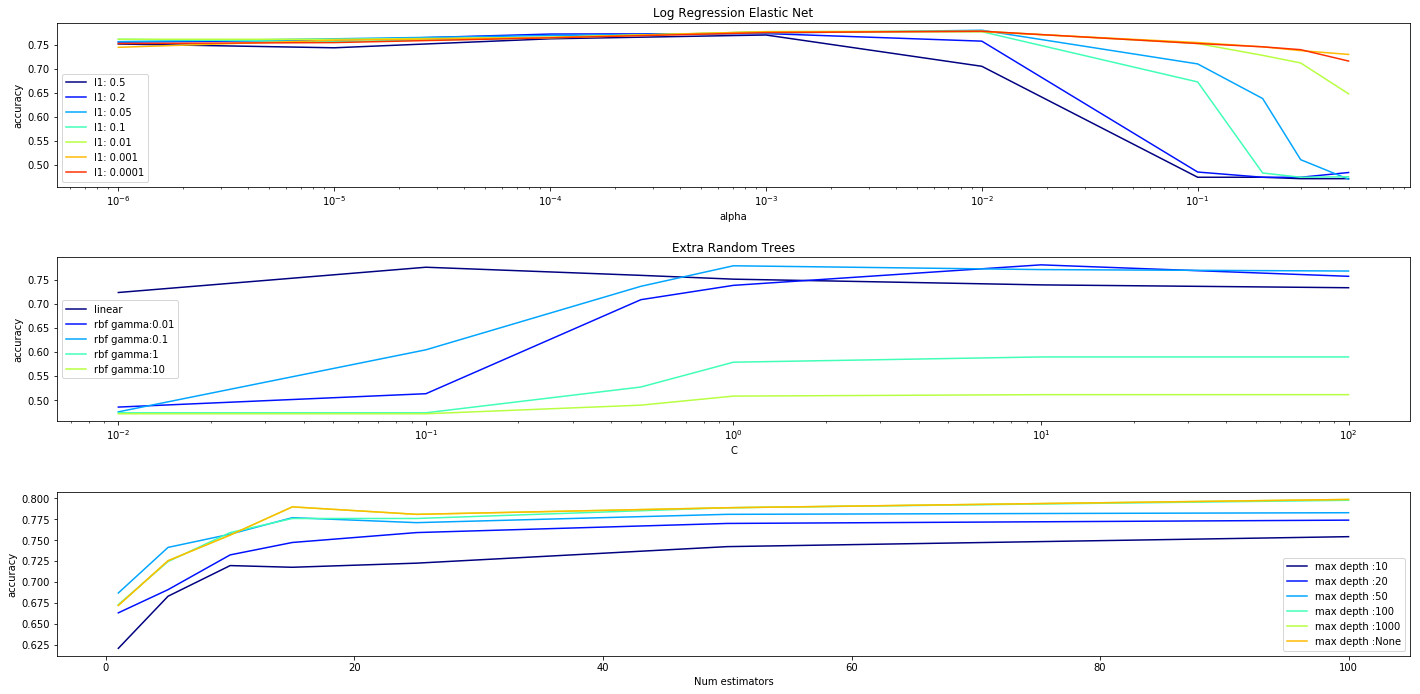

In [8]:
import numpy as np
import random
import readFeatureFiles
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import cm


#test classifier in ten-fold cross-validation
#returns avg accuracy
def validateClassifier(outfile, classifier, features, y_vars, regression):
    avg_accuracy = 0.0
    for i in range(0, 10):
        (training_x, training_y, val_x, val_y) = splitData(features, y_vars, i, 10)
        #scale features if regression classifier
        if regression:
            min_max_scaler = preprocessing.MinMaxScaler()
            training_x = min_max_scaler.fit_transform(training_x)
            val_x = min_max_scaler.transform(val_x)
        classifier.fit(training_x, training_y)
        score = classifier.score(val_x, val_y)
        avg_accuracy += score
        outfile.write(str(score) + ",")
    avg_accuracy /= 10.0
    return avg_accuracy

#parameters
#classification to train classifiers on 
#options: antibacterial, antieuk (defined as antifungal, antitumor, or cytotoxic), antifungal, cytotoxic_antitumor, antigramneg, antigrampos
classification = "antibacterial" 
#set random seed so results are consistent
random.seed(1)
#include features from SSN 
include_SSN = True

pfam_features = readFeatureMatrix("feature_matrices/PFAM.csv")
card_features = readFeatureMatrix("feature_matrices/CARD_gene.csv")
smCOG_features = readFeatureMatrix("feature_matrices/SMCOG.csv")
SSN_features = readFeatureMatrix("feature_matrices/SSN.csv")
CDS_features = readFeatureMatrix("feature_matrices/CDS_motifs.csv")

pks_nrps_type_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pks_nrps_type.csv")
pk_signature_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_signature.csv")
pk_minowa_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_minowa.csv")
pk_consensus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_consensus.csv")

nrp_stachelhaus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_stachelhaus.csv")
nrp_nrpspredictor_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_nrpspredictor.csv")
nrp_pHMM_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_pHMM.csv")
nrp_predicat_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_predicat.csv")
nrp_sandpuma_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_sandpuma.csv")

pfam_list = readFeatureFiles.readFeatureList("feature_matrices/pfam_list.txt")
card_list = readFeatureFiles.readFeatureList("feature_matrices/CARD_gene_list.txt")
smCOG_list = readFeatureFiles.readFeatureList("feature_matrices/smCOG_list.txt")
SSN_list = readFeatureFiles.readFeatureList("feature_matrices/SSN_list.txt")
CDS_list = readFeatureFiles.readFeatureList("feature_matrices/CDS_motifs_list.txt")

pks_nrps_type_list = readFeatureFiles.readFeatureList("feature_matrices/pks_nrps_type_list.txt")
pk_signature_list = readFeatureFiles.readFeatureList("feature_matrices/pk_signature_list.txt")
pk_minowa_list = readFeatureFiles.readFeatureList("feature_matrices/pk_minowa_list.txt")
pk_consensus_list = readFeatureFiles.readFeatureList("feature_matrices/pk_consensus_list.txt")

nrp_stachelhaus_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_stachelhaus_list.txt")
nrp_nrpspredictor_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_nrpspredictor_list.txt")
nrp_pHMM_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_pHMM_list.txt")
nrp_predicat_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_predicat_list.txt")
nrp_sandpuma_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_sandpuma_list.txt")

#read classes
is_antibacterial = readFeatureFiles.readClassesMatrix("feature_matrices/is_antibacterial.csv")
is_antifungal = readFeatureFiles.readClassesMatrix("feature_matrices/is_antifungal.csv")
is_cytotoxic = readFeatureFiles.readClassesMatrix("feature_matrices/is_cytotoxic.csv")
is_unknown = readFeatureFiles.readClassesMatrix("feature_matrices/is_unknown.csv")
targets_gram_pos = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_pos.csv")
targets_gram_neg = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_neg.csv")
full_cluster_list = readFeatureFiles.readClusterList("feature_matrices/cluster_list_CARD.txt")
is_not_unknown_indices = readFeatureFiles.getNotUnknownIndices(is_unknown)
target_unannotated = is_antibacterial*((targets_gram_pos+targets_gram_neg)<1)
is_not_unknown_indices_gram =  readFeatureFiles.getNotUnknownIndices(is_unknown + target_unannotated)

is_antibacterial = (is_antibacterial >= 1).astype(int)
is_antieuk = ((is_antifungal + is_cytotoxic)>=1).astype(int)
is_gram_pos = (targets_gram_pos >= 1).astype(int)
is_gram_neg = (targets_gram_neg >= 1).astype(int)

#concatenate all features into one matrix
features = np.concatenate((pfam_features, card_features), axis=1)
features = np.concatenate((features,  smCOG_features), axis=1)
features = np.concatenate((features,  CDS_features), axis=1)
if include_SSN:
    features = np.concatenate((features,  SSN_features), axis=1)
features = np.concatenate((features,  pks_nrps_type_features), axis=1)
features = np.concatenate((features,  pk_signature_features), axis=1)
features = np.concatenate((features,  pk_minowa_features), axis=1)
features = np.concatenate((features,  pk_consensus_features), axis=1)
features = np.concatenate((features,  nrp_stachelhaus_features), axis=1)
features = np.concatenate((features,  nrp_nrpspredictor_features), axis=1)
features = np.concatenate((features,  nrp_pHMM_features), axis=1)
features = np.concatenate((features,  nrp_predicat_features), axis=1)
features = np.concatenate((features,  nrp_sandpuma_features), axis=1)

#process features for chosen classification
y_vars = []
if classification == "antibacterial":
    y_vars = is_antibacterial
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
if classification == "antieuk":
    y_vars = is_antieuk
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
if classification == "antifungal":
    y_vars = (is_antifungal >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
if classification == "cytotoxic_antitumor":
    y_vars = (is_cytotoxic >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
if classification == "antigramneg":
    y_vars = is_gram_neg
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
if classification == "antigrampos":
    y_vars = is_gram_pos
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
    
#randomize order of features
new_order = makeRandomOrder(0, y_vars)
y_vars = y_vars[new_order]
features = features[new_order,:]

#parameter values to test for logistic regression
l1_ratios = [.5, .2, .05, .1, .01, .001, .0001]
alphas = [.5, .3, .2, .1, .01,  .001,  .0001,.00001,.000001]
log_accuracies = {}
max_iter = 100
loss = "log"
reg= "elasticnet"

#test parameters for logistic regression
for l1_ratio in l1_ratios:
    log_accuracies[l1_ratio] =  {}
    accuracy_outfile = open("classifier_optimization/log_"+classification+loss+"_"+reg+str(l1_ratio)+"_alpha_vs_accuracy.txt",'w')
    for a in alphas:
        classifier = SGDClassifier(loss=loss,penalty=reg,max_iter=max_iter,alpha=a,l1_ratio=l1_ratio,tol=None)
        accuracy_outfile.write(str(a) + ",")
        log_accuracies[l1_ratio][a]= validateClassifier(accuracy_outfile, classifier, features, y_vars, True)
        accuracy_outfile.write("\n")
    accuracy_outfile.close()
    
    
#parameter values to test for SVM classifier
kernels = ['linear', 'rbf']
c_values = [100, 10, 1, .5, .1, .01]
gammas = [.01, .1, 1, 10] #for rbf only

svm_accuracies = {}
#test parameters
for k in kernels:
    if k == "linear":
        svm_accuracies[k] = {}
        accuracy_outfile = open("classifier_optimization/SVM_"+classification + "_" +k+"_c_vs_accuracy.txt",'w')
        for c in c_values:
            classifier = SVC(kernel=k,C=c)
            accuracy_outfile.write(str(c) + ",")
            svm_accuracies[k][c]=validateClassifier(accuracy_outfile, classifier, features, y_vars, True)  
            accuracy_outfile.write("\n")
        accuracy_outfile.close()
    if k == "rbf":
        svm_accuracies[k] = {}
        for g in gammas:
            accuracy_outfile = open("classifier_optimization/SVM_"+classification + "_" +k+"_"+str(g)+"_c_vs_accuracy.txt",'w')
            svm_accuracies[k][g] = {}
            for c in c_values:
                classifier = SVC(kernel=k,C=c, gamma=g)
                accuracy_outfile.write(str(c) + ",")
                svm_accuracies[k][g][c] = validateClassifier(accuracy_outfile, classifier, features, y_vars,True)
                accuracy_outfile.write("\n")
            accuracy_outfile.close()
            
random.seed(1)            
#parameters for random forest classifier
n_estimators = [1, 5, 10, 15, 25, 50, 100]
max_depths = [10, 20, 50, 100, 1000, None]
bootstrap = True
max_features = 'auto'
criterion = 'gini'

#optimize random forest classifier
forest_accuracies = {}
for d in max_depths:
    forest_accuracies[d] = {}
    accuracy_outfile = open("classifier_optimization/RT_"+classification + "_" +str(d)+"_estimators_vs_accuracy.txt",'w')
    for n in n_estimators:
        accuracy_outfile.write(str(n)+",")
        classifier = ExtraTreesClassifier(n_estimators=n, max_depth=d,bootstrap=bootstrap, max_features=max_features, criterion=criterion, random_state=0)
        forest_accuracies[d][n] = validateClassifier(accuracy_outfile, classifier, features, y_vars, False)
        accuracy_outfile.write("\n")
    accuracy_outfile.close()
    
#visualize results
fig, axs = plt.subplots(3, figsize=(20, 10))

cmap = cm.get_cmap('jet')
colors = []
for i in range(0, 7):
    colors.append(cmap(i*1.0/7.0))
    
i = 0

for l1_ratio in l1_ratios:
    y_values = []
    for a in alphas:
        y_values.append(log_accuracies[l1_ratio][a])
    axs[0].plot(alphas, y_values,  color=colors[i], label="l1: " + str(l1_ratio))
    i += 1

axs[0].legend()
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('alpha')
axs[0].set_xscale('log')
axs[0].set_title('Log Regression Elastic Net')

y_values = []
for c in c_values:
    y_values.append(svm_accuracies['linear'][c])
axs[1].plot(c_values, y_values, color=colors[0], label='linear')

i = 1    
for g in gammas:
    y_values = []
    for c in c_values:
        y_values.append(svm_accuracies['rbf'][g][c])
    axs[1].plot(c_values, y_values, color=colors[i], label='rbf gamma:' + str(g))
    i += 1

axs[1].legend()
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('C')
axs[1].set_xscale('log')
axs[1].set_title('SVM')

i = 0
for d in max_depths:
    y_values = []
    for n in n_estimators:
        y_values.append(forest_accuracies[d][n])
    axs[2].plot(n_estimators,y_values, color=colors[i], label='max depth :' + str(d))
    i += 1

axs[2].legend()
axs[2].set_ylabel('accuracy')
axs[2].set_xlabel('Num estimators')
axs[1].set_title('Extra Random Trees')

fig.tight_layout(pad=2.0)

#print optimal parameters
max_accuracy_log = 0
optimal_alpha = 0
optimal_l1_ratio = 0
for l1_ratio in l1_ratios:
    for a in alphas:
        if log_accuracies[l1_ratio][a] > max_accuracy_log:
            max_accuracy_log = log_accuracies[l1_ratio][a]
            optimal_alpha = a
            optimal_l1_ratio = l1_ratio
            
print "Log regression maximum accuracy: " + str(max_accuracy_log)
print "Optimal l1 ratio: " + str(optimal_l1_ratio) + " optimal alpha: " + str(optimal_alpha)
print ""

max_accuracy_svm = 0
optimal_kernel = ""
optimal_gamma = 0
optimal_c = 0
for c in c_values:
    if svm_accuracies['linear'][c] > max_accuracy_svm:
        max_accuracy_svm = svm_accuracies['linear'][c]
        optimal_kernel = 'linear'
        optimal_c = c
    for g in gammas:
        if svm_accuracies['rbf'][g][c] > max_accuracy_svm:
            max_accuracy_svm = svm_accuracies['rbf'][g][c]
            optimal_kernel = 'rbf'
            optimal_c = c
            optimal_gamma = g
            
print "SVM maximum accuracy: " + str(max_accuracy_svm)
if optimal_kernel == 'linear':
    print "Optimal kernel: linear optimal c: " + str(optimal_c)
else:
    print "Optimal kernel: rbf optimal c: " + str(optimal_c) + " optimal gamma: " + str(optimal_gamma)
print ""

max_accuracy_forest = 0
optimal_depth = 0
optimal_n = 0
for d in max_depths:
    for n in n_estimators:
        if forest_accuracies[d][n] > max_accuracy_forest:
            max_accuracy_forest = forest_accuracies[d][n]
            optimal_depth = d
            optimal_n = n
print "Extra random trees maximum accuracy: " + str(max_accuracy_forest)
print "Optimal depth: " + str(d) + " optimal n estimators: " + str(optimal_n)

# Evaluate classifiers

evaluates classifiers by various accuracy metrics.

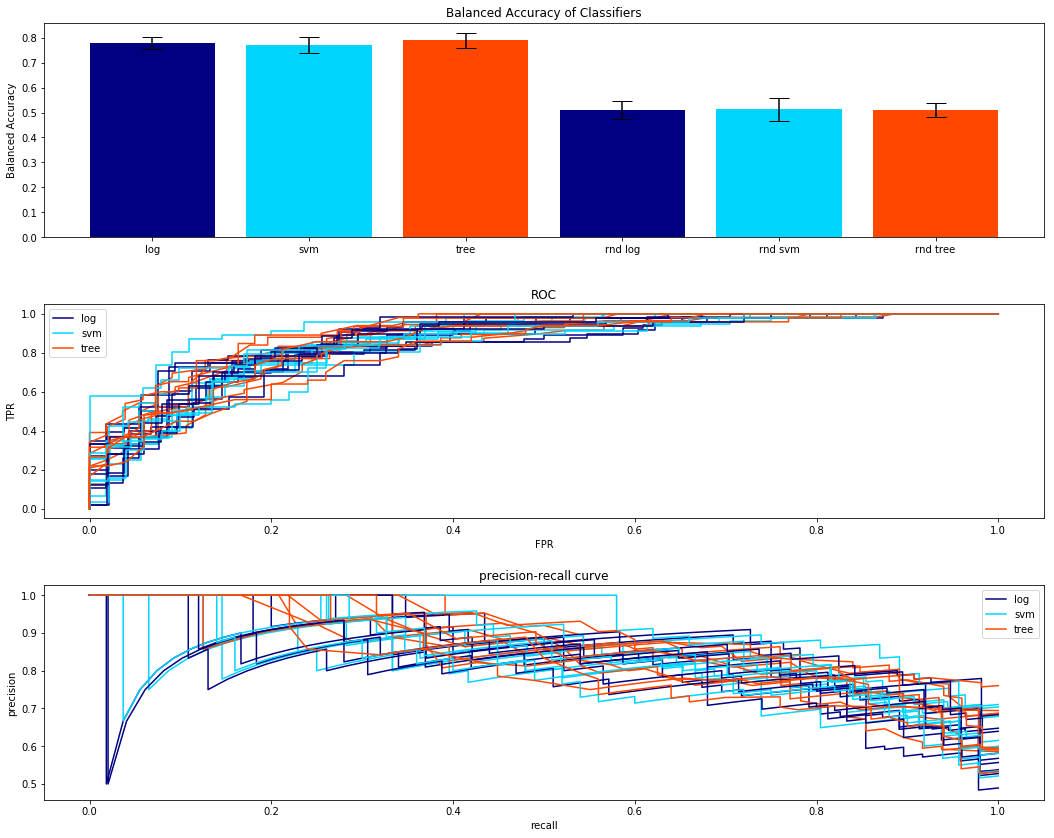

In [7]:
import numpy as np
import random
import readFeatureFiles
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve


def randomizeFeatures(seed, features):
    np.random.seed(seed)
    random_features = features
    for i in range(0, features.shape[1]):
        y_vars_range = np.arange(features.shape[0])
        np.random.shuffle(y_vars_range)
        random_features[y_vars_range,:]
    return random_features

def writeCurve(outfile, x_axis, y_axis):
    for i in range(0, x_axis.shape[0]):
        outfile.write(str(x_axis[i]) + "," + str(y_axis[i]) + "\n")

#parameters
classification = "antibacterial" 
#set random seed so results are consistent
random.seed(1)
#include features from SSN 
include_SSN = True 
#parameters for classifiers
log_params = {}
log_params["antibacterial"] = {"l1_ratio":.05,"alpha":.01}
log_params["antigrampos"] = {"l1_ratio":.001,"alpha":.001}
log_params["antigramneg"] = {"l1_ratio":.05,"alpha":.001}
log_params["antieuk"] = {"l1_ratio":.001,"alpha":.001}
log_params["antifungal"] = {"l1_ratio":.0001,"alpha":.01}
log_params["cytotoxic_antitumor"] = {"l1_ratio":.001,"alpha":.001}

svm_params = {}
svm_params["antibacterial"] = {"kernel":'rbf',"C":10,"gamma":0.1}
svm_params["antigrampos"] = {"kernel":'rbf',"C":10,"gamma":.01}
svm_params["antigramneg"] = {"kernel":'rbf',"C":10,"gamma":0.01}
svm_params["antieuk"] = {"kernel":'linear',"C":.1}
svm_params["antifungal"] = {"kernel":'rbf',"C":10,"gamma":0.1}
svm_params["cytotoxic_antitumor"] = {"kernel":'rbf',"C":100,"gamma":0.1}

forest_params = {}
forest_params["antibacterial"] = {"depth":100,"n":50}
forest_params["antigrampos"] = {"depth":100,"n":50}
forest_params["antigramneg"] = {"depth":100,"n":25}
forest_params["antieuk"] = {"depth":None,"n":25}
forest_params["antifungal"] = {"depth":50,"n":50}
forest_params["cytotoxic_antitumor"] = {"depth":50,"n":100}

#read in features
pfam_features = readFeatureFiles.readFeatureMatrix("feature_matrices/PFAM.csv")
card_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CARD_gene.csv")
smCOG_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SMCOG.csv")
SSN_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SSN.csv")
CDS_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CDS_motifs.csv")


pks_nrps_type_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pks_nrps_type.csv")
pk_signature_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_signature.csv")
pk_minowa_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_minowa.csv")
pk_consensus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_consensus.csv")

nrp_stachelhaus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_stachelhaus.csv")
nrp_nrpspredictor_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_nrpspredictor.csv")
nrp_pHMM_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_pHMM.csv")
nrp_predicat_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_predicat.csv")
nrp_sandpuma_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_sandpuma.csv")

features = np.concatenate((pfam_features, card_features), axis=1)
features = np.concatenate((features,  smCOG_features), axis=1)
features = np.concatenate((features,  CDS_features), axis=1)
if include_SSN:
    features = np.concatenate((features,  SSN_features), axis=1)
features = np.concatenate((features,  pks_nrps_type_features), axis=1)
features = np.concatenate((features,  pk_signature_features), axis=1)
features = np.concatenate((features,  pk_minowa_features), axis=1)
features = np.concatenate((features,  pk_consensus_features), axis=1)
features = np.concatenate((features,  nrp_stachelhaus_features), axis=1)
features = np.concatenate((features,  nrp_nrpspredictor_features), axis=1)
features = np.concatenate((features,  nrp_pHMM_features), axis=1)
features = np.concatenate((features,  nrp_predicat_features), axis=1)
features = np.concatenate((features,  nrp_sandpuma_features), axis=1)

#make randomly shuffled version of features
features_rand = randomizeFeatures(0, features)

is_antibacterial = readFeatureFiles.readClassesMatrix("feature_matrices/is_antibacterial.csv")
is_antifungal = readFeatureFiles.readClassesMatrix("feature_matrices/is_antifungal.csv")
is_cytotoxic = readFeatureFiles.readClassesMatrix("feature_matrices/is_cytotoxic.csv")
is_unknown = readFeatureFiles.readClassesMatrix("feature_matrices/is_unknown.csv")
targets_gram_pos = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_pos.csv")
targets_gram_neg = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_neg.csv")
full_cluster_list = readFeatureFiles.readClusterList("feature_matrices/cluster_list_CARD.txt")
is_not_unknown_indices = readFeatureFiles.getNotUnknownIndices(is_unknown)
target_unannotated = is_antibacterial*((targets_gram_pos+targets_gram_neg)<1)
is_not_unknown_indices_gram =  readFeatureFiles.getNotUnknownIndices(is_unknown + target_unannotated)

is_antibacterial = (is_antibacterial >= 1).astype(int)
is_antieuk = ((is_antifungal + is_cytotoxic)>=1).astype(int)
is_gram_pos = (targets_gram_pos >= 1).astype(int)
is_gram_neg = (targets_gram_neg >= 1).astype(int)

y_vars = []
if classification == "antibacterial":
    y_vars = is_antibacterial
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antieuk":
    y_vars = is_antieuk
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]

    
if classification == "antifungal":
    y_vars = (is_antifungal >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "cytotoxic_antitumor":
    y_vars = (is_cytotoxic >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antigramneg":
    y_vars = is_gram_neg
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
    
if classification == "antigrampos":
    y_vars = is_gram_pos
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
    
#reorder features
new_order = makeRandomOrder(0, y_vars)
y_vars = y_vars[new_order]
features = features[new_order,:]
features_rand = features_rand[new_order, :]

#initialize classifiers
opt_log_params = log_params[classification]
log_classifier = SGDClassifier(loss='log',penalty='elasticnet',max_iter=100,alpha=opt_log_params["alpha"],l1_ratio=opt_log_params["l1_ratio"],tol=None)

opt_svm_params = svm_params[classification]
if opt_svm_params['kernel'] == "linear":
    svm_classifier = SVC(kernel="linear",C=opt_svm_params["C"], probability=True)
else:
    svm_classifier = SVC(kernel="rbf",C=opt_svm_params["C"], gamma=opt_svm_params["gamma"], probability=True)
    
opt_forest_params = forest_params[classification]
tree_classifier = ExtraTreesClassifier(bootstrap=True,max_features="auto",n_estimators=opt_forest_params["n"], max_depth=opt_forest_params["depth"], random_state=0)

#do analysis, write to file, and visualize
output_fname_base = "classifier_metrics/" + classification + "_"

#output files
roc_out = open(output_fname_base + "roc.txt", 'w')
pr_out = open(output_fname_base + "precision_recall.txt", 'w')
accuracy_out = open(output_fname_base + "accuracy.txt", "w")
balanced_accuracy_out = open(output_fname_base + "balanced_accuracy.txt", "w")

#cross validation
#store results in dictionary for visualization
roc_curves = {}
roc_curves["log"] = {}
roc_curves["svm"] = {}
roc_curves["tree"] = {}
roc_curves["rnd_log"] = {}
roc_curves["rnd_svm"] = {}
roc_curves["rnd_tree"] = {}

pr_curves = {}
pr_curves["log"] = {}
pr_curves["svm"] = {}
pr_curves["tree"] = {}
pr_curves["rnd_log"] = {}
pr_curves["rnd_svm"] = {}
pr_curves["rnd_tree"] = {}

accuracies = {}
accuracies["log"] = []
accuracies["svm"] = []
accuracies["tree"] = []
accuracies["rnd_log"] = []
accuracies["rnd_svm"] = []
accuracies["rnd_tree"] = []

b_accuracies = {}
b_accuracies["log"] = []
b_accuracies["svm"] = []
b_accuracies["tree"] = []
b_accuracies["rnd_log"] = []
b_accuracies["rnd_svm"] = []
b_accuracies["rnd_tree"] = []

for i in range(0, 10):
    (training_x, training_y, val_x, val_y) = splitData(features, y_vars, i, 10)
    (rnd_training_x, rnd_training_y, rnd_val_x, rnd_val_y) = splitData(features_rand, y_vars, i, 10)
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_training_x = min_max_scaler.fit_transform(training_x)
    scaled_val_x = min_max_scaler.transform(val_x)
    scaled_rnd_training_x = min_max_scaler.fit_transform(rnd_training_x)
    scaled_rnd_val_x = min_max_scaler.transform(rnd_val_x)
    
    #metrics for classifiers fit to real data
    svm_classifier.fit(scaled_training_x, training_y)
    tree_classifier.fit(training_x, training_y)
    log_classifier.fit(scaled_training_x, training_y)
    
    accuracy_out.write(str(svm_classifier.score(scaled_val_x, val_y))+",")
    accuracy_out.write(str(log_classifier.score(scaled_val_x, val_y))+",")
    accuracy_out.write(str(tree_classifier.score(val_x, val_y))+",")
    accuracies["log"].append(log_classifier.score(scaled_val_x, val_y))
    accuracies["svm"].append(svm_classifier.score(scaled_val_x, val_y))
    accuracies["tree"].append(tree_classifier.score(val_x, val_y))
    
    balanced_accuracy_out.write(str(balanced_accuracy_score(val_y,svm_classifier.predict(scaled_val_x))) + ",")
    balanced_accuracy_out.write(str(balanced_accuracy_score(val_y,log_classifier.predict(scaled_val_x))) + ",")
    balanced_accuracy_out.write(str(balanced_accuracy_score(val_y,tree_classifier.predict(val_x))) + ",")
    b_accuracies["log"].append(balanced_accuracy_score(val_y,log_classifier.predict(scaled_val_x)))
    b_accuracies["svm"].append(balanced_accuracy_score(val_y,svm_classifier.predict(scaled_val_x)))
    b_accuracies["tree"].append(balanced_accuracy_score(val_y,tree_classifier.predict(val_x)))
    
    tree_probabilities = tree_classifier.predict_proba(val_x)
    log_probabilities = log_classifier.predict_proba(scaled_val_x)
    svm_probabilities = svm_classifier.predict_proba(scaled_val_x)
    
    fpr, tpr, thresholds = roc_curve(val_y, tree_probabilities[:,1])
    roc_curves["tree"][i] = (fpr, tpr)
    fpr, tpr, thresholds = roc_curve(val_y, svm_probabilities[:,1])
    roc_curves["svm"][i] = (fpr, tpr)
    fpr, tpr, thresholds = roc_curve(val_y, log_probabilities[:,1])
    roc_curves["log"][i] = (fpr, tpr)
    
    precision, recall, thresholds = precision_recall_curve(val_y, tree_probabilities[:,1])
    pr_curves["tree"][i] = (recall, precision)
    precision, recall, thresholds = precision_recall_curve(val_y, svm_probabilities[:,1])
    pr_curves["svm"][i] = (recall, precision)
    precision, recall, thresholds = precision_recall_curve(val_y, log_probabilities[:,1])
    pr_curves["log"][i] = (recall, precision)
    
    
    #metrics for classifiers fit to randomly scrambled data
    svm_classifier.fit(scaled_rnd_training_x, rnd_training_y)
    tree_classifier.fit(rnd_training_x, rnd_training_y)
    log_classifier.fit(scaled_rnd_training_x, rnd_training_y)
    
    accuracy_out.write(str(svm_classifier.score(scaled_rnd_val_x, rnd_val_y))+",")
    accuracy_out.write(str(log_classifier.score(scaled_rnd_val_x, rnd_val_y))+",")
    accuracy_out.write(str(tree_classifier.score(rnd_val_x, rnd_val_y))+",")
    accuracies["rnd_log"].append(log_classifier.score(scaled_rnd_val_x, rnd_val_y))
    accuracies["rnd_svm"].append(svm_classifier.score(scaled_rnd_val_x, rnd_val_y))
    accuracies["rnd_tree"].append(tree_classifier.score(rnd_val_x, rnd_val_y))
    
    balanced_accuracy_out.write(str(balanced_accuracy_score(rnd_val_y,svm_classifier.predict(scaled_rnd_val_x))) + ",")
    balanced_accuracy_out.write(str(balanced_accuracy_score(rnd_val_y,log_classifier.predict(scaled_rnd_val_x))) + ",")
    balanced_accuracy_out.write(str(balanced_accuracy_score(rnd_val_y,tree_classifier.predict(rnd_val_x))) + ",")
    b_accuracies["rnd_log"].append(balanced_accuracy_score(rnd_val_y,log_classifier.predict(scaled_rnd_val_x)))
    b_accuracies["rnd_svm"].append(balanced_accuracy_score(rnd_val_y,svm_classifier.predict(scaled_rnd_val_x)))
    b_accuracies["rnd_tree"].append(balanced_accuracy_score(rnd_val_y,tree_classifier.predict(rnd_val_x)))
    
    tree_probabilities = tree_classifier.predict_proba(rnd_val_x)
    log_probabilities = log_classifier.predict_proba(scaled_rnd_val_x)
    svm_probabilities = svm_classifier.predict_proba(scaled_rnd_val_x)
    
    fpr, tpr, thresholds = roc_curve(rnd_val_y, tree_probabilities[:,1])
    roc_curves["rnd_tree"][i] = (fpr, tpr)
    fpr, tpr, thresholds = roc_curve(rnd_val_y, svm_probabilities[:,1])
    roc_curves["rnd_svm"][i] = (fpr, tpr)
    fpr, tpr, thresholds = roc_curve(rnd_val_y, log_probabilities[:,1])
    roc_curves["rnd_log"][i] = (fpr, tpr)
    
    precision, recall, thresholds = precision_recall_curve(rnd_val_y, tree_probabilities[:,1])
    pr_curves["rnd_tree"][i] = (recall, precision)
    recision, recall, thresholds = precision_recall_curve(rnd_val_y, svm_probabilities[:,1])
    pr_curves["rnd_svm"][i] = (recall, precision)
    precision, recall, thresholds = precision_recall_curve(rnd_val_y, log_probabilities[:,1])
    pr_curves["rnd_log"][i] = (recall, precision)
    
    balanced_accuracy_out.write("\n")
    accuracy_out.write("\n")
    
accuracy_out.close()
balanced_accuracy_out.close()

#write ROC and pr curves for one trial
writeCurve(roc_out, roc_curves["svm"][0][0],roc_curves["svm"][0][1])
writeCurve(roc_out, roc_curves["log"][0][0],roc_curves["log"][0][1])
writeCurve(roc_out, roc_curves["tree"][0][0],roc_curves["tree"][0][1])
writeCurve(roc_out, roc_curves["rnd_svm"][0][0],roc_curves["rnd_svm"][0][1])
writeCurve(roc_out, roc_curves["rnd_log"][0][0],roc_curves["rnd_log"][0][1])
writeCurve(roc_out, roc_curves["rnd_tree"][0][0],roc_curves["rnd_tree"][0][1])
roc_out.close()

writeCurve(pr_out, pr_curves["svm"][0][0],pr_curves["svm"][0][1])
writeCurve(pr_out, pr_curves["log"][0][0],pr_curves["log"][0][1])
writeCurve(pr_out, pr_curves["tree"][0][0],pr_curves["tree"][0][1])
writeCurve(pr_out, pr_curves["rnd_svm"][0][0],pr_curves["rnd_svm"][0][1])
writeCurve(pr_out, pr_curves["rnd_log"][0][0],pr_curves["rnd_log"][0][1])
writeCurve(pr_out, pr_curves["rnd_tree"][0][0],pr_curves["rnd_tree"][0][1])
pr_out.close

#visualize results
fig, axs = plt.subplots(3, figsize=(15, 12))
cmap = cm.get_cmap('jet')
colors = []
for i in range(0, 6):
    colors.append(cmap(i*1.0/6.0))
    
mean_log_acc = np.mean(b_accuracies["log"])
mean_svm_acc = np.mean(b_accuracies["svm"])
mean_tree_acc = np.mean(b_accuracies["tree"])
mean_rnd_log_acc =np.mean(b_accuracies["rnd_log"])
mean_rnd_svm_acc = np.mean(b_accuracies["rnd_svm"])
mean_rnd_tree_acc = np.mean(b_accuracies["rnd_tree"])

mean_log_sd = np.std(b_accuracies["log"])
mean_svm_sd = np.std(b_accuracies["svm"])
mean_tree_sd = np.std(b_accuracies["tree"])
mean_rnd_log_sd =np.std(b_accuracies["rnd_log"])
mean_rnd_svm_sd = np.std(b_accuracies["rnd_svm"])
mean_rnd_tree_sd = np.std(b_accuracies["rnd_tree"])

bar_labels = ["log", "svm", "tree", "rnd log", "rnd svm", "rnd tree"]
x_pos = np.arange(len(bar_labels))
means = [mean_log_acc, mean_svm_acc, mean_tree_acc, mean_rnd_log_acc, mean_rnd_svm_acc, mean_rnd_tree_acc]
error = [mean_log_sd, mean_svm_sd, mean_tree_sd, mean_rnd_log_sd, mean_rnd_svm_sd, mean_rnd_tree_sd]
axs[0].bar(x_pos, means, yerr=error, align='center', capsize=10, color=(colors[0], colors[2], colors[5],colors[0], colors[2], colors[5]))
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(bar_labels)
axs[0].set_title("Balanced Accuracy of Classifiers")
axs[0].set_ylabel("Balanced Accuracy")

axs[1].plot(roc_curves["log"][0][0], roc_curves["log"][0][1], color=colors[0], label='log')
axs[1].plot(roc_curves["svm"][0][0], roc_curves["svm"][0][1], color=colors[2], label='svm')
axs[1].plot(roc_curves["tree"][0][0], roc_curves["tree"][0][1], color=colors[5], label='tree')
for i in range(1, 10):
    axs[1].plot(roc_curves["log"][i][0], roc_curves["log"][i][1], color=colors[0])
    axs[1].plot(roc_curves["svm"][i][0], roc_curves["svm"][i][1], color=colors[2])
    axs[1].plot(roc_curves["tree"][i][0], roc_curves["tree"][i][1], color=colors[5])
axs[1].set_title("ROC")
axs[1].set_ylabel("TPR")
axs[1].set_xlabel("FPR")
axs[1].legend()


axs[2].plot(pr_curves["log"][0][0], pr_curves["log"][0][1], color=colors[0], label='log')
axs[2].plot(pr_curves["svm"][0][0], pr_curves["svm"][0][1], color=colors[2], label='svm')
axs[2].plot(pr_curves["tree"][0][0], pr_curves["tree"][0][1], color=colors[5], label='tree')
for i in range(1, 10):
    axs[2].plot(pr_curves["log"][i][0], pr_curves["log"][i][1], color=colors[0])
    axs[2].plot(pr_curves["svm"][i][0], pr_curves["svm"][i][1], color=colors[2])
    axs[2].plot(pr_curves["tree"][i][0], pr_curves["tree"][i][1], color=colors[5])
axs[2].set_title("precision-recall curve")
axs[2].set_ylabel("precision")
axs[2].set_xlabel("recall")
axs[2].legend()
fig.tight_layout(pad=2.0)


# Analyze Features
Prints top and bottom 10 features based on logistic regression coefficients, writes full list of coefficients to file

In [9]:
import numpy as np
import random
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
import readFeatureFiles

#classification to rank features for
classification = "antibacterial"
#set random seed so results are consistent
random.seed(1)
#include features from SSN 
include_SSN = True

#parameters for classifiers
log_params = {}
log_params["antibacterial"] = {"l1_ratio":.05,"alpha":.01}
log_params["antigrampos"] = {"l1_ratio":.001,"alpha":.001}
log_params["antigramneg"] = {"l1_ratio":.05,"alpha":.001}
log_params["antieuk"] = {"l1_ratio":.001,"alpha":.001}
log_params["antifungal"] = {"l1_ratio":.0001,"alpha":.01}
log_params["cytotoxic_antitumor"] = {"l1_ratio":.001,"alpha":.001}


#read in features
pfam_features = readFeatureFiles.readFeatureMatrix("feature_matrices/PFAM.csv")
card_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CARD_gene.csv")
smCOG_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SMCOG.csv")
SSN_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SSN.csv")
CDS_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CDS_motifs.csv")


pks_nrps_type_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pks_nrps_type.csv")
pk_signature_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_signature.csv")
pk_minowa_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_minowa.csv")
pk_consensus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_consensus.csv")

nrp_stachelhaus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_stachelhaus.csv")
nrp_nrpspredictor_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_nrpspredictor.csv")
nrp_pHMM_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_pHMM.csv")
nrp_predicat_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_predicat.csv")
nrp_sandpuma_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_sandpuma.csv")

#read in list of feature lables
pfam_list = readFeatureFiles.readFeatureList("feature_matrices/pfam_list.txt")
card_list = readFeatureFiles.readFeatureList("feature_matrices/CARD_gene_list.txt")
smCOG_list = readFeatureFiles.readFeatureList("feature_matrices/smCOG_list.txt")
SSN_list = readFeatureFiles.readFeatureList("feature_matrices/SSN_list.txt")
CDS_list = readFeatureFiles.readFeatureList("feature_matrices/CDS_motifs_list.txt")

pks_nrps_type_list = readFeatureFiles.readFeatureList("feature_matrices/pks_nrps_type_list.txt")
pk_signature_list = readFeatureFiles.readFeatureList("feature_matrices/pk_signature_list.txt")
pk_minowa_list = readFeatureFiles.readFeatureList("feature_matrices/pk_minowa_list.txt")
pk_consensus_list = readFeatureFiles.readFeatureList("feature_matrices/pk_consensus_list.txt")

nrp_stachelhaus_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_stachelhaus_list.txt")
nrp_nrpspredictor_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_nrpspredictor_list.txt")
nrp_pHMM_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_pHMM_list.txt")
nrp_predicat_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_predicat_list.txt")
nrp_sandpuma_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_sandpuma_list.txt")

#concatenate features
features = np.concatenate((pfam_features, card_features), axis=1)
features = np.concatenate((features,  smCOG_features), axis=1)
features = np.concatenate((features,  CDS_features), axis=1)
if include_SSN:
    features = np.concatenate((features,  SSN_features), axis=1)
features = np.concatenate((features,  pks_nrps_type_features), axis=1)
features = np.concatenate((features,  pk_signature_features), axis=1)
features = np.concatenate((features,  pk_minowa_features), axis=1)
features = np.concatenate((features,  pk_consensus_features), axis=1)
features = np.concatenate((features,  nrp_stachelhaus_features), axis=1)
features = np.concatenate((features,  nrp_nrpspredictor_features), axis=1)
features = np.concatenate((features,  nrp_pHMM_features), axis=1)
features = np.concatenate((features,  nrp_predicat_features), axis=1)
features = np.concatenate((features,  nrp_sandpuma_features), axis=1)

feature_list = pfam_list +card_list+smCOG_list+CDS_list+SSN_list+pks_nrps_type_list+pk_signature_list+pk_minowa_list+pk_consensus_list+nrp_stachelhaus_list+nrp_nrpspredictor_list+nrp_pHMM_list+nrp_predicat_list+nrp_sandpuma_list


is_antibacterial = readFeatureFiles.readClassesMatrix("feature_matrices/is_antibacterial.csv")
is_antifungal = readFeatureFiles.readClassesMatrix("feature_matrices/is_antifungal.csv")
is_cytotoxic = readFeatureFiles.readClassesMatrix("feature_matrices/is_cytotoxic.csv")
is_unknown = readFeatureFiles.readClassesMatrix("feature_matrices/is_unknown.csv")
targets_gram_pos = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_pos.csv")
targets_gram_neg = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_neg.csv")
full_cluster_list = readFeatureFiles.readClusterList("feature_matrices/cluster_list_CARD.txt")
is_not_unknown_indices = readFeatureFiles.getNotUnknownIndices(is_unknown)
target_unannotated = is_antibacterial*((targets_gram_pos+targets_gram_neg)<1)
is_not_unknown_indices_gram =  readFeatureFiles.getNotUnknownIndices(is_unknown + target_unannotated)

is_antibacterial = (is_antibacterial >= 1).astype(int)
is_antieuk = ((is_antifungal + is_cytotoxic)>=1).astype(int)
is_gram_pos = (targets_gram_pos >= 1).astype(int)
is_gram_neg = (targets_gram_neg >= 1).astype(int)

y_vars = []
if classification == "antibacterial":
    y_vars = is_antibacterial
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antieuk":
    y_vars = is_antieuk
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]

    
if classification == "antifungal":
    y_vars = (is_antifungal >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "cytotoxic_antitumor":
    y_vars = (is_cytotoxic >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antigramneg":
    y_vars = is_gram_neg
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
    
if classification == "antigrampos":
    y_vars = is_gram_pos
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]

#train logistic regression classifier    
min_max_scaler = preprocessing.MinMaxScaler()
scaled_training_x = min_max_scaler.fit_transform(features)
opt_log_params = log_params[classification]
log_classifier = SGDClassifier(loss='log',penalty='elasticnet',max_iter=100,alpha=opt_log_params["alpha"],l1_ratio=opt_log_params["l1_ratio"],tol=None)
log_classifier.fit(scaled_training_x, y_vars)

#get and sort coefficients and write results to file
log_coeff = log_classifier.coef_[0]
index_log_coeff = np.argsort(-1*log_coeff)
output_log = open("feature_scores/"+classification+"_log_coeff.txt",'w')
for i in index_log_coeff:
    output_log.write(feature_list[i].replace(",","_")+",")
    output_log.write(str(log_coeff[i])+"\n")
output_log.close()

#print top and bottom 10 classifiers and coefficients
for i in range(0, 10):
    print feature_list[index_log_coeff[i]] + ": " + str(log_coeff[index_log_coeff[i]])
print ""                                                                
for i in range(0, 10):
    print feature_list[index_log_coeff[len(index_log_coeff)-(i+1)]] + ": " + str(log_coeff[index_log_coeff[len(index_log_coeff)-(i+1)]])                                                             

Peptidase C39 family: 0.5877299257274852
bcrA: 0.5112584862261972
tcmA: 0.42040178673197615
SMCOG1288:ABC_transporter_related_protein: 0.3935196340086145
SpaB C-terminal domain: 0.38209260945578266
Lanthionine synthetase C-like protein: 0.3791754370502538
Lantibiotic dehydratase, N terminus: 0.37840469645062547
 PKS/NRPS-like protein: 0.3594521154120028
sav1866: 0.35451693757005454
Integral membrane protein DUF95: 0.34232299367500113

Putative S-adenosyl-L-methionine-dependent methyltransferase: -0.39481675518309167
thioesterase_3: -0.31894617224524185
Squalene/phytoene synthase: -0.3085973109000007
Bacterial sugar transferase: -0.30405168696360163
SMCOG1146:sugar_transferase: -0.30405168696360163
ABC transporter transmembrane region 2: -0.3013497486906876
O-antigen ligase like membrane protein: -0.296129679499589
mal: -0.27821048103585005
Glycosyl transferase family 2: -0.27572469704927155
Glycosyltransferase like family 2: -0.2707694267737134


# Write Feature Matrices for new BGCs
Determines features for new BGCs so that their activity can be predicted. 

Determining SSN features for new clusters requires blast to be installed and is slow. Set include_SSN = False in this cell and the next to not include SSN features. This has a minimal effect on accuracy. If you are using SSNs blast_exe must be set to the full path of the blastp executable.

antiSMASH and RGI results must have matching files. File extension for antiSMASH results must be .gbk and the file extension for the RGI results must be .txt.

In [10]:
import os
import SSN_tools
import readFeatureFiles
from Bio import SeqIO

new_BGCs_dir = "BGCs_for_prediction/"
include_SSN = True
blast_exe = "" #blast is required to determine SSN membership, set include SSN to false to skip this step
e_value_threshold = 0.1
score_cutoff = 20

SSN_pfam_names = ["Thiolase, N-terminal domain","ABC transporter","Acyl transferase domain","AAA domain",
                 "ABC-2 family transporter protein","Acyl-CoA dehydrogenase, C-terminal domain","Acyl-CoA dehydrogenase, N-terminal domain",
                 "Alcohol dehydrogenase GroES-like domain","Alpha/beta hydrolase family","Aminotransferase class I and II",
                 "Beta-ketoacyl synthase, C-terminal domain","Beta-ketoacyl synthase, N-terminal domain","Cytochrome P450","DegT/DnrJ/EryC1/StrS aminotransferase family",
                 "Enoyl-(Acyl carrier protein) reductase","Erythronolide synthase docking","FAD binding domain","Glycosyl transferase family 2",
                 "Glycosyltransferase family 28 N-terminal domain","Glycosyl transferases group 1","Glycosyltransferase like family 2","Glyoxalase/Bleomycin resistance protein/Dioxygenase superfamily",
                 "KR domain","Lanthionine synthetase C-like protein",
                 "Major Facilitator Superfamily","Methyltransferase small domain","Methyltransferase domain",
                 "NAD dependent epimerase/dehydratase family","NDP-hexose 2,3-dehydratase",
                 "O-methyltransferase","Oxidoreductase family, C-terminal alpha/beta domain","Oxidoreductase family, NAD-binding Rossmann fold",
                 "Phosphopantetheine attachment site","Polyketide cyclase / dehydrase and lipid transport","Polyketide synthase dehydratase",
                 "Protein of unknown function (DUF1205)",
                 "short chain dehydrogenase","SnoaL-like domain","SpaB C-terminal domain",
                 "Sugar (and other) transporter","transcriptional_regulatory_protein,_c_terminal_domains","Thioesterase superfamily","ubiE/COQ5 methyltransferase family","UDP-glucoronosyl and UDP-glucosyl transferase","YcaO-like family",
                 "Zinc-binding dehydrogenase","pyridine_nucleotide-disulphide_oxidoreductase"]


#read in list of features to use
used_pfam_list = readFeatureFiles.readFeatureList("feature_matrices/pfam_list.txt")
used_CDS_list = readFeatureFiles.readFeatureList("feature_matrices/CDS_motifs_list.txt")
used_smCOG_list = readFeatureFiles.readFeatureList("feature_matrices/smCOG_list.txt")
used_pks_nrps_type_list = readFeatureFiles.readFeatureList("feature_matrices/pks_nrps_type_list.txt")
used_pk_signature_list = readFeatureFiles.readFeatureList("feature_matrices/pk_signature_list.txt")
used_pk_minowa_list = readFeatureFiles.readFeatureList("feature_matrices/pk_minowa_list.txt")
used_pk_consensus_list = readFeatureFiles.readFeatureList("feature_matrices/pk_consensus_list.txt")
    
used_nrp_stachelhaus_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_stachelhaus_list.txt")
used_nrp_nrps_predictor_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_nrpspredictor_list.txt")
used_nrp_pHMM_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_pHMM_list.txt")
used_nrp_predicat_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_predicat_list.txt")
used_nrp_sandpuma_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_sandpuma_list.txt")
    
used_resistance_genes_list = readFeatureFiles.readFeatureList("feature_matrices/CARD_gene_list.txt")
SSN_list = readFeatureFiles.readFeatureList("feature_matrices/SSN_list.txt")

#read files
CDS_motifs = {}
smCOGs = {}
pfam_counts = {}
pks_nrp_subtypes = {}

pk_monomers_signature = {}
pk_monomers_minowa = {}
pk_monomers_consensus = {}


nrp_monomers_stachelhaus = {}
nrp_monomers_nrps_predictor = {}
nrp_monomers_pHMM = {}
nrp_monomers_predicat = {}
nrp_monomers_sandpuma = {}

resistance_genes = {}

cluster_list = []
CARD_cluster_list = []
for f in os.listdir(new_BGCs_dir + "antiSMASH"):
    if ".gb" not in f and ".gbk" not in f:
        continue
    
    record = SeqIO.read(open(new_BGCs_dir + "antiSMASH/" + f, 'rU'),"genbank")
    features = record.features
    cluster_name = f[0:f.rfind(".")]
    cluster_list.append(cluster_name)
    
    CDS_motifs[cluster_name] = {}
    smCOGs[cluster_name] = {}
    pfam_counts[cluster_name] = {}
    pks_nrp_subtypes[cluster_name] = {}
    pk_monomers_signature[cluster_name] = {}
    pk_monomers_minowa[cluster_name] = {}
    pk_monomers_consensus[cluster_name] = {}
    nrp_monomers_stachelhaus[cluster_name] = {}
    nrp_monomers_nrps_predictor[cluster_name] = {}
    nrp_monomers_pHMM[cluster_name] = {}
    nrp_monomers_predicat[cluster_name] = {}
    nrp_monomers_sandpuma[cluster_name] = {}
    subtype = ""
    pks_signature = ""
    minowa = ""
    consensus = ""
    stachelhaus = ""
    nrpspredictor = ""
    pHMM = ""
    predicat = ""
    sandpuma = ""
    for feature in features:
        subtype = ""
        pks_signature = ""
        minowa = ""
        consensus = ""
        stachelhaus = ""
        nrpspredictor = ""
        pHMM = ""
        predicat = ""
        sandpuma = ""
        if feature.type == "CDS":
            if "sec_met" not in feature.qualifiers:
                continue
            for f in feature.qualifiers["sec_met"]:
                if "NRPS/PKS subtype" in f:
                    subtype = f.split(":")[1]
                    
                if "Substrate specificity predictions" in f:
                    #print f
                    if "PKS_AT" in f:
                        predictions = f.split(":")[4]
                        #print predictions
                        pks_signature = predictions.split(",")[0].split()[0]
                        minowa = predictions.split(",")[1].split()[0]
                        consensus = predictions.split(",")[2].split()[0]
                    if "AMP-binding" in f:
                        predictions = f.split(":")[5]
                        stachelhaus = predictions.split(",")[0].split()[0]
                        nrpspredictor = predictions.split(",")[1].split()[0]
                        pHMM = predictions.split(",")[2].split()[0]
                        predicat = predictions.split(",")[3].split()[0]
                        sandpuma = predictions.split(",")[4].split()[0]
        if subtype != "":
            if subtype not in pks_nrp_subtypes[cluster_name]:
                pks_nrp_subtypes[cluster_name][subtype] = 0
            pks_nrp_subtypes[cluster_name][subtype] += 1
        if pks_signature != "" and "no_call" not in pks_signature and "N/A" not in pks_signature and "n/a" not in pks_signature:
            if pks_signature not in pk_monomers_signature[cluster_name]:
                pk_monomers_signature[cluster_name][pks_signature] = 0
            pk_monomers_signature[cluster_name][pks_signature] += 1
        if minowa != "" and "no_call" not in minowa and "N/A" not in minowa and "n/a" not in minowa:
            if minowa not in pk_monomers_minowa[cluster_name]:
                pk_monomers_minowa[cluster_name][minowa] = 0
            pk_monomers_minowa[cluster_name][minowa] += 1
        if consensus != "" and "no_call" not in consensus and "N/A" not in consensus and "n/a" not in consensus:
            if consensus not in pk_monomers_consensus[cluster_name]:
                pk_monomers_consensus[cluster_name][consensus] = 0
            pk_monomers_consensus[cluster_name][consensus] += 1
        if stachelhaus != "" and "no_call" not in stachelhaus and "N/A" not in stachelhaus and "n/a" not in stachelhaus:
            if stachelhaus not in nrp_monomers_stachelhaus[cluster_name]:
                nrp_monomers_stachelhaus[cluster_name][stachelhaus] = 0
            nrp_monomers_stachelhaus[cluster_name][stachelhaus] += 1
        if nrpspredictor != "" and "no_call" not in nrpspredictor and "N/A" not in nrpspredictor and "n/a" not in nrpspredictor:
            if nrpspredictor not in nrp_monomers_nrps_predictor[cluster_name]:
                nrp_monomers_nrps_predictor[cluster_name][nrpspredictor] = 0
            nrp_monomers_nrps_predictor[cluster_name][nrpspredictor] += 1
        if pHMM != "" and "no_call" not in pHMM and "N/A" not in pHMM and "n/a" not in pHMM:
            if pHMM not in nrp_monomers_pHMM[cluster_name]:
                nrp_monomers_pHMM[cluster_name][pHMM] = 0
            nrp_monomers_pHMM[cluster_name][pHMM] += 1
        if predicat != "" and "no_call" not in predicat and "N/A" not in predicat and "n/a" not in predicat:
            if predicat not in nrp_monomers_predicat[cluster_name]:
                nrp_monomers_predicat[cluster_name][predicat] = 0
            nrp_monomers_predicat[cluster_name][predicat] += 1
        if sandpuma != "" and "no_call" not in sandpuma and "N/A" not in sandpuma and "n/a" not in sandpuma:
            if sandpuma not in nrp_monomers_sandpuma[cluster_name]:
                nrp_monomers_sandpuma[cluster_name][sandpuma] = 0
            nrp_monomers_sandpuma[cluster_name][sandpuma] += 1
            
            
        if feature.type == "CDS_motif":
            note_text = feature.qualifiers['note'][0]
            if "(" not in note_text:
                continue
            motif_name = note_text[0:note_text.index("(")-1]
            if motif_name not in CDS_motifs[cluster_name]:
                CDS_motifs[cluster_name][motif_name] = 0
            CDS_motifs[cluster_name][motif_name] += 1
        elif feature.type == "CDS":
            if "note" in feature.qualifiers:
                for note in feature.qualifiers["note"]:
                    if "smCOG" in note:
                        if ":" not in note or "(" not in note:
                            continue
                        smCOG_type = note[note.index(":")+2:note.index("(")-1]
                        if smCOG_type not in smCOG_list:
                            smCOG_list.append(smCOG_type)
                            smCOG_total_counts[smCOG_type] = 0
                        if smCOG_type not in smCOGs[cluster_name]:
                            smCOGs[cluster_name][smCOG_type] = 0
                        smCOGs[cluster_name][smCOG_type] += 1
                        smCOG_total_counts[smCOG_type] += 1
        elif feature.type == "PFAM_domain":
            score = float(feature.qualifiers["score"][0])
            if score <score_cutoff:
                continue
            domain_description = feature.qualifiers["description"][0]
            pfam_id = feature.qualifiers["db_xref"][0]
            pfam_id = pfam_id[pfam_id.find(" ")+1:len(pfam_id)]

            if domain_description not in pfam_counts[cluster_name]:
                pfam_counts[cluster_name][domain_description] = 0
            pfam_counts[cluster_name][domain_description] += 1
            
for f in os.listdir(new_BGCs_dir + "CARD"):
    if ".txt" not in f:
        continue
    cluster_name = f[0:f.rfind(".")]
    CARD_cluster_list.append(cluster_name)
    resistance_genes[cluster_name] = {}
    in_file = open(new_BGCs_dir + "CARD/" +f, 'r')
    for line in in_file:
        if "ORF_ID" in line:
            continue
        entries = line.split("\t")
        #print in_file
        #print entries
        e_value = float(entries[7])
        if e_value > e_value_threshold:
            continue
        best_hit = entries[8]
        hit_names = entries[11]
        if best_hit not in resistance_genes[cluster_name]:
            resistance_genes[cluster_name][best_hit] = 0
        resistance_genes[cluster_name][best_hit] += 1
    in_file.close()

#only use clusters that have both antiSMASH and CARD file
cluster_list = [c for c in cluster_list if c in CARD_cluster_list]

#write feature matrices
CDS_motif_only_output = open(new_BGCs_dir + "CDS_motifs.csv",'w')
SMCOG_only_output = open(new_BGCs_dir + "SMCOG.csv",'w')
pfam_output = open(new_BGCs_dir + "PFAM.csv",'w')
cluster_list_out = open(new_BGCs_dir + "cluster_list.txt",'w')
pks_nrps_type_output = open(new_BGCs_dir + "pks_nrps_type.csv",'w')
pk_signature_output = open(new_BGCs_dir + "pk_signature.csv",'w')
pk_minowa_output = open(new_BGCs_dir + "pk_minowa.csv",'w')
pk_consensus_output = open(new_BGCs_dir + "pk_consensus.csv",'w')
nrp_stachelhaus_output = open(new_BGCs_dir + "nrp_stachelhaus.csv",'w')
nrp_nrpspredictor_output = open(new_BGCs_dir + "nrp_nrpspredictor.csv",'w')
nrp_pHMM_output = open(new_BGCs_dir + "nrp_pHMM.csv",'w')
nrp_predicat_output = open(new_BGCs_dir + "nrp_predicat.csv",'w')
nrp_sandpuma_output = open(new_BGCs_dir + "nrp_sandpuma.csv",'w')
resistance_output = open(new_BGCs_dir + "CARD_gene.csv", "w")

for cluster in cluster_list:
    cluster_list_out.write(cluster + "\n")
    for CDS_motif in used_CDS_list:
        if CDS_motif in CDS_motifs[cluster]:
            CDS_motif_only_output.write(str(CDS_motifs[cluster][CDS_motif]) +",")
        else:
            CDS_motif_only_output.write("0,")
            
    for smCOG in used_smCOG_list:
        if smCOG in smCOGs[cluster]:
            SMCOG_only_output.write(str(smCOGs[cluster][smCOG]) +",")
        else:
            SMCOG_only_output.write("0,")
            
    for pfam in used_pfam_list:
        if pfam in pfam_counts[cluster]:
            pfam_output.write(str(pfam_counts[cluster][pfam]) +",")
        else:
            pfam_output.write("0,")
            
    for pks_nrp_type in used_pks_nrps_type_list:
        if pks_nrp_type in pks_nrp_subtypes[cluster]:
            pks_nrps_type_output.write(str(pks_nrp_subtypes[cluster][pks_nrp_type]) +",")
        else:
            pks_nrps_type_output.write("0,")
            
    for pk in used_pk_signature_list:
        if pk in pk_monomers_signature[cluster]:
            pk_signature_output.write(str(pk_monomers_signature[cluster][pk]) +",")
        else:
            pk_signature_output.write("0,")
        
    for pk in used_pk_minowa_list:
        if pk in pk_monomers_minowa[cluster]:
            pk_minowa_output.write(str(pk_monomers_minowa[cluster][pk]) +",")
        else:
            pk_minowa_output.write("0,")
            
    for pk in used_pk_consensus_list:
        if pk in pk_monomers_consensus[cluster]:
            pk_consensus_output.write(str(pk_monomers_consensus[cluster][pk]) +",")
        else:
            pk_consensus_output.write("0,")
            
    for nrp in used_nrp_stachelhaus_list:
        if nrp in nrp_monomers_stachelhaus[cluster]:
            nrp_stachelhaus_output.write(str(nrp_monomers_stachelhaus[cluster][nrp]) +",")
        else:
            nrp_stachelhaus_output.write("0,")
    
    for nrp in used_nrp_nrps_predictor_list:
        if nrp in nrp_monomers_nrps_predictor[cluster]:
            nrp_nrpspredictor_output.write(str(nrp_monomers_nrps_predictor[cluster][nrp]) +",")
        else:
            nrp_nrpspredictor_output.write("0,")
            
    for nrp in used_nrp_pHMM_list:
        if nrp in nrp_monomers_pHMM[cluster]:
            nrp_pHMM_output.write(str(nrp_monomers_pHMM[cluster][nrp]) +",")
        else:
            nrp_pHMM_output.write("0,")
    
    for nrp in used_nrp_predicat_list:
        if nrp in nrp_monomers_predicat[cluster]:
            nrp_predicat_output.write(str(nrp_monomers_predicat[cluster][nrp]) +",")
        else:
            nrp_predicat_output.write("0,")
            
    for nrp in used_nrp_sandpuma_list:
        if nrp in nrp_monomers_sandpuma[cluster]:
            nrp_sandpuma_output.write(str(nrp_monomers_sandpuma[cluster][nrp]) +",")
        else:
            nrp_sandpuma_output.write("0,")
            
    for gene in used_resistance_genes_list:
        if cluster not in resistance_genes or gene not in resistance_genes[cluster]:
            resistance_output.write("0,")
        else:
            resistance_output.write(str(resistance_genes[cluster][gene])+",")
        
    CDS_motif_only_output.write('\n')
    SMCOG_only_output.write('\n')
    pfam_output.write("\n")
    pks_nrps_type_output.write("\n")
    pk_signature_output.write("\n")
    pk_minowa_output.write("\n")
    pk_consensus_output.write("\n")
    nrp_stachelhaus_output.write("\n")
    nrp_nrpspredictor_output.write("\n")
    nrp_pHMM_output.write("\n")
    nrp_predicat_output.write("\n")
    nrp_sandpuma_output.write("\n")
    resistance_output.write("\n")

CDS_motif_only_output.close()
pfam_output.close()
SMCOG_only_output.close()
cluster_list_out.close()
    
pks_nrps_type_output.close()
pk_signature_output.close()
pk_minowa_output.close()
pk_consensus_output.close()
nrp_stachelhaus_output.close()
nrp_nrpspredictor_output.close()
nrp_pHMM_output.close()
nrp_predicat_output.close()
nrp_sandpuma_output.close()    
resistance_output.close()

if include_SSN:
    outfile = open(new_BGCs_dir+ "SSN.csv",'w')
    included_clusters =  {}
    for pfam_name in SSN_list:
        base = pfam_name[0:pfam_name.rfind("_")]
        if base not in included_clusters:
            included_clusters[base] = []
        numbering = pfam_name[pfam_name.rfind("_")+1:len(pfam_name)].replace("\r","")
        included_clusters[base].append(numbering.replace("\n",""))
        
    for cluster in cluster_list:
        f = new_BGCs_dir +"antiSMASH/" + cluster + ".gbk"
        test_SSN_feature_matrix = SSN_tools.generateSSNFeatureMatrix([f], SSN_pfam_names, SSN_list, included_clusters, blast_exe)
        row = test_SSN_feature_matrix[0,:]
        for v in row:
            outfile.write(str(int(v))+",")
        outfile.write("\n")
    outfile.close()

# Make predictions for new BGCs
makes activity predictions for new clusters. 

In [11]:
import numpy as np
import random
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
import readFeatureFiles

#directories for input files
features_for_predictions_dir = "BGCs_for_prediction/"
outfile = open(features_for_predictions_dir + "probability_predictions.txt", 'w')

classification = "antibacterial"
#set random seed so results are consistent
random.seed(1)
#include features from SSN 
include_SSN = True

#parameters for classifiers
log_params = {}
log_params["antibacterial"] = {"l1_ratio":.05,"alpha":.01}
log_params["antigrampos"] = {"l1_ratio":.001,"alpha":.001}
log_params["antigramneg"] = {"l1_ratio":.05,"alpha":.001}
log_params["antieuk"] = {"l1_ratio":.001,"alpha":.001}
log_params["antifungal"] = {"l1_ratio":.0001,"alpha":.01}
log_params["cytotoxic_antitumor"] = {"l1_ratio":.001,"alpha":.001}

svm_params = {}
svm_params["antibacterial"] = {"kernel":'rbf',"C":10,"gamma":0.1}
svm_params["antigrampos"] = {"kernel":'rbf',"C":10,"gamma":.01}
svm_params["antigramneg"] = {"kernel":'rbf',"C":10,"gamma":0.01}
svm_params["antieuk"] = {"kernel":'linear',"C":.1}
svm_params["antifungal"] = {"kernel":'rbf',"C":10,"gamma":0.1}
svm_params["cytotoxic_antitumor"] = {"kernel":'rbf',"C":100,"gamma":0.1}

forest_params = {}
forest_params["antibacterial"] = {"depth":100,"n":50}
forest_params["antigrampos"] = {"depth":100,"n":50}
forest_params["antigramneg"] = {"depth":100,"n":25}
forest_params["antieuk"] = {"depth":None,"n":25}
forest_params["antifungal"] = {"depth":50,"n":50}
forest_params["cytotoxic_antitumor"] = {"depth":50,"n":100}

#read in features
pfam_features = readFeatureFiles.readFeatureMatrix("feature_matrices/PFAM.csv")
card_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CARD_gene.csv")
smCOG_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SMCOG.csv")
SSN_features = readFeatureFiles.readFeatureMatrix("feature_matrices/SSN.csv")
CDS_features = readFeatureFiles.readFeatureMatrix("feature_matrices/CDS_motifs.csv")


pks_nrps_type_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pks_nrps_type.csv")
pk_signature_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_signature.csv")
pk_minowa_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_minowa.csv")
pk_consensus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/pk_consensus.csv")

nrp_stachelhaus_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_stachelhaus.csv")
nrp_nrpspredictor_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_nrpspredictor.csv")
nrp_pHMM_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_pHMM.csv")
nrp_predicat_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_predicat.csv")
nrp_sandpuma_features = readFeatureFiles.readFeatureMatrix("feature_matrices/nrp_sandpuma.csv")

#read in list of feature lables
pfam_list = readFeatureFiles.readFeatureList("feature_matrices/pfam_list.txt")
card_list = readFeatureFiles.readFeatureList("feature_matrices/CARD_gene_list.txt")
smCOG_list = readFeatureFiles.readFeatureList("feature_matrices/smCOG_list.txt")
SSN_list = readFeatureFiles.readFeatureList("feature_matrices/SSN_list.txt")
CDS_list = readFeatureFiles.readFeatureList("feature_matrices/CDS_motifs_list.txt")

pks_nrps_type_list = readFeatureFiles.readFeatureList("feature_matrices/pks_nrps_type_list.txt")
pk_signature_list = readFeatureFiles.readFeatureList("feature_matrices/pk_signature_list.txt")
pk_minowa_list = readFeatureFiles.readFeatureList("feature_matrices/pk_minowa_list.txt")
pk_consensus_list = readFeatureFiles.readFeatureList("feature_matrices/pk_consensus_list.txt")

nrp_stachelhaus_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_stachelhaus_list.txt")
nrp_nrpspredictor_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_nrpspredictor_list.txt")
nrp_pHMM_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_pHMM_list.txt")
nrp_predicat_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_predicat_list.txt")
nrp_sandpuma_list = readFeatureFiles.readFeatureList("feature_matrices/nrp_sandpuma_list.txt")

#concatenate features
features = np.concatenate((pfam_features, card_features), axis=1)
features = np.concatenate((features,  smCOG_features), axis=1)
features = np.concatenate((features,  CDS_features), axis=1)
if include_SSN:
    features = np.concatenate((features,  SSN_features), axis=1)
features = np.concatenate((features,  pks_nrps_type_features), axis=1)
features = np.concatenate((features,  pk_signature_features), axis=1)
features = np.concatenate((features,  pk_minowa_features), axis=1)
features = np.concatenate((features,  pk_consensus_features), axis=1)
features = np.concatenate((features,  nrp_stachelhaus_features), axis=1)
features = np.concatenate((features,  nrp_nrpspredictor_features), axis=1)
features = np.concatenate((features,  nrp_pHMM_features), axis=1)
features = np.concatenate((features,  nrp_predicat_features), axis=1)
features = np.concatenate((features,  nrp_sandpuma_features), axis=1)

feature_list = pfam_list +card_list+smCOG_list+CDS_list+SSN_list+pks_nrps_type_list+pk_signature_list+pk_minowa_list+pk_consensus_list+nrp_stachelhaus_list+nrp_nrpspredictor_list+nrp_pHMM_list+nrp_predicat_list+nrp_sandpuma_list

is_antibacterial = readFeatureFiles.readClassesMatrix("feature_matrices/is_antibacterial.csv")
is_antifungal = readFeatureFiles.readClassesMatrix("feature_matrices/is_antifungal.csv")
is_cytotoxic = readFeatureFiles.readClassesMatrix("feature_matrices/is_cytotoxic.csv")
is_unknown = readFeatureFiles.readClassesMatrix("feature_matrices/is_unknown.csv")
targets_gram_pos = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_pos.csv")
targets_gram_neg = readFeatureFiles.readClassesMatrix("feature_matrices/targets_gram_neg.csv")
full_cluster_list = readFeatureFiles.readClusterList("feature_matrices/cluster_list_CARD.txt")
is_not_unknown_indices = readFeatureFiles.getNotUnknownIndices(is_unknown)
target_unannotated = is_antibacterial*((targets_gram_pos+targets_gram_neg)<1)
is_not_unknown_indices_gram =  readFeatureFiles.getNotUnknownIndices(is_unknown + target_unannotated)

is_antibacterial = (is_antibacterial >= 1).astype(int)
is_antieuk = ((is_antifungal + is_cytotoxic)>=1).astype(int)
is_gram_pos = (targets_gram_pos >= 1).astype(int)
is_gram_neg = (targets_gram_neg >= 1).astype(int)

y_vars = []
if classification == "antibacterial":
    y_vars = is_antibacterial
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antieuk":
    y_vars = is_antieuk
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]

    
if classification == "antifungal":
    y_vars = (is_antifungal >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "cytotoxic_antitumor":
    y_vars = (is_cytotoxic >= 1).astype(int)
    y_vars = y_vars[is_not_unknown_indices]
    features = features[is_not_unknown_indices,:]
    
if classification == "antigramneg":
    y_vars = is_gram_neg
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]
    
if classification == "antigrampos":
    y_vars = is_gram_pos
    y_vars = y_vars[is_not_unknown_indices_gram]
    features = features[is_not_unknown_indices_gram,:]

#train classifiers
min_max_scaler = preprocessing.MinMaxScaler()
scaled_training_x = min_max_scaler.fit_transform(features)
opt_log_params = log_params[classification]
log_classifier = SGDClassifier(loss='log',penalty='elasticnet',max_iter=100,alpha=opt_log_params["alpha"],l1_ratio=opt_log_params["l1_ratio"],tol=None)
opt_svm_params = svm_params[classification]
if opt_svm_params['kernel'] == "linear":
    svm_classifier = SVC(kernel="linear",C=opt_svm_params["C"], probability=True)
else:
    svm_classifier = SVC(kernel="rbf",C=opt_svm_params["C"], gamma=opt_svm_params["gamma"], probability=True)
    
opt_forest_params = forest_params[classification]
tree_classifier = ExtraTreesClassifier(bootstrap=True,max_features="auto",n_estimators=opt_forest_params["n"], max_depth=opt_forest_params["depth"], random_state=0)

log_classifier.fit(scaled_training_x, y_vars)
svm_classifier.fit(scaled_training_x, y_vars)
tree_classifier.fit(features, y_vars)

#read features for new predictions
new_cluster_list = readFeatureFiles.readClusterList(features_for_predictions_dir + "cluster_list.txt")
new_pfam_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "PFAM.csv")
new_card_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "CARD_gene.csv")
new_smCOG_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "SMCOG.csv")
if include_SSN:
    new_SSN_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "SSN.csv")
new_CDS_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "CDS_motifs.csv")


new_pks_nrps_type_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "pks_nrps_type.csv")
new_pk_signature_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "pk_signature.csv")
new_pk_minowa_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "pk_minowa.csv")
new_pk_consensus_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "pk_consensus.csv")

new_nrp_stachelhaus_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "nrp_stachelhaus.csv")
new_nrp_nrpspredictor_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "nrp_nrpspredictor.csv")
new_nrp_pHMM_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "nrp_pHMM.csv")
new_nrp_predicat_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "nrp_predicat.csv")
new_nrp_sandpuma_features = readFeatureFiles.readFeatureMatrix(features_for_predictions_dir + "nrp_sandpuma.csv")


#concatenate features
new_features = np.concatenate((new_pfam_features, new_card_features), axis=1)
new_features = np.concatenate((new_features,  new_smCOG_features), axis=1)
new_features = np.concatenate((new_features, new_CDS_features), axis=1)
if include_SSN:
    new_features = np.concatenate((new_features,  new_SSN_features), axis=1)
new_features = np.concatenate((new_features,  new_pks_nrps_type_features), axis=1)
new_features = np.concatenate((new_features,  new_pk_signature_features), axis=1)
new_features = np.concatenate((new_features,  new_pk_minowa_features), axis=1)
new_features = np.concatenate((new_features,  new_pk_consensus_features), axis=1)
new_features = np.concatenate((new_features,  new_nrp_stachelhaus_features), axis=1)
new_features = np.concatenate((new_features,  new_nrp_nrpspredictor_features), axis=1)
new_features = np.concatenate((new_features,  new_nrp_pHMM_features), axis=1)
new_features = np.concatenate((new_features,  new_nrp_predicat_features), axis=1)
new_features = np.concatenate((new_features,  new_nrp_sandpuma_features), axis=1)

#make predictions
scaled_new_x = min_max_scaler.transform(new_features)
log_probabilities = log_classifier.predict_proba(scaled_new_x)
svm_probabilities = svm_classifier.predict_proba(scaled_new_x)
tree_probabilities = tree_classifier.predict_proba(new_features)

#write and print results
i = 0
for c in new_cluster_list:
    outfile.write(c + ",")
    outfile.write(str(log_probabilities[i][1]) + ",")
    outfile.write(str(svm_probabilities[i][1]) + ",")
    outfile.write(str(tree_probabilities[i][1]) + ",")
    outfile.write("\n")
    
    print c + ":"
    print "log: " + str(log_probabilities[i][1])
    print "svm: " + str(svm_probabilities[i][1])
    print "tree: " + str(tree_probabilities[i][1])
    print ""
    i += 1
outfile.close()

cluster_example1:
log: 0.5926362533740391
svm: 0.7345418900729421
tree: 0.86

cluster_example2:
log: 0.42368066524461745
svm: 0.6683806021008427
tree: 0.48

